## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from collections import deque

%matplotlib inline

cv2.destroyAllWindows()


In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = [] 
        self.radius_of_curvature_m = [] 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None



In [14]:
class Pipeline():
    def __init__(self):
        # Create two lines
        self.l_line = Line()
        self.r_line = Line()
        self.current_frame = []
        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        self.M = []
        self.Minv = [] 
        self.mtx=[]
        self.perspective_src = []
        self.perspective_dst = []
        self.distance_from_centre_m = []
        self.dist =[]
        self.calibrate()
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    def push_frame(self, frame):
        # Add frame to pipeline
        self.current_frame = frame
    
    # Pipeline 
    def undistort(self, frame, plot_enabled = False):
        dst = cv2.undistort(frame, self.mtx, self.dist, None, self.mtx)
        return dst.astype(np.uint8)
    
    def binary(self, img, sobel_threshold = [20, 55], color_threshold = [220, 255], plot_enabled = False):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
    
        # Sobel x
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
        # Threshold x gradient
        thresh_min = sobel_threshold[0]
        thresh_max = sobel_threshold[1]
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        
        # Threshold color channels
        s_thresh_min = color_threshold[0]
        s_thresh_max = color_threshold[1]
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
        l_thresh_min = color_threshold[0]
        l_thresh_max = color_threshold[1]
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
        
        # Combine the three binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (l_binary == 1) | (sxbinary == 1)] = 255
        color_binary = np.dstack(( s_binary, l_binary, sxbinary)) * 255
        if plot_enabled:
            cv2.imwrite('color_binary.png', color_binary)
        return combined_binary.astype(np.uint8)
        
    def curvature_pixels_to_meters(self, leftx, rightx, y_eval, ploty):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/60 # meters per pixel in x dimension
        
        # Fit new polynomials to x,y in world space
        print("SHAPES!")
        print(np.shape(ploty))
        print(np.shape(leftx))
        print(np.shape(rightx))
        print("SHAPES!")
        left_fit_cr = np.polyfit(ploty, leftx, 2)
        right_fit_cr = np.polyfit(ploty, rightx, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Example values: 632.1 m    626.2 m
        return left_curverad, right_curverad
    
    def findline(self, binary_warped, plot_enabled = False):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        cv2.imwrite("lines_rectangles.png", out_img)
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
        # Fit a second order polynomial to each
        if (len(left_lane_inds)>2):
            left_fit = np.polyfit(lefty, leftx, 2)
            self.l_line.current_fit = left_fit
            self.l_line.detected = True
            if (np.all(self.l_line.best_fit) != None):
                self.l_line.best_fit = self.l_line.best_fit*0.8 + self.l_line.current_fit*0.2
            else:
                self.l_line.best_fit = left_fit    
            left_fitx = self.l_line.best_fit[0]*ploty**2 + self.l_line.best_fit[1]*ploty + self.l_line.best_fit[2]
            self.l_line.recent_xfitted = left_fitx
        else:
            self.l_line.detected = False
            left_fitx = self.l_line.recent_xfitted
        
        if (len(right_lane_inds)>2):
            right_fit = np.polyfit(righty, rightx, 2)
            self.r_line.current_fit = right_fit
            self.r_line.detected = True
            if (np.all(self.r_line.best_fit) != None):
                self.r_line.best_fit = self.r_line.best_fit*0.8 + self.r_line.current_fit*0.2
            else:
                self.r_line.best_fit = right_fit
            my = self.ym_per_pix
            mx = self.xm_per_pix
            right_fitx = self.r_line.best_fit[0]*ploty**2 + self.r_line.best_fit[1]*ploty + self.r_line.best_fit[2]
            self.r_line.recent_xfitted = right_fitx
        else:
            self.r_line.detected = False
            right_fitx = self.r_line.recent_xfitted
        

        
        if plot_enabled:
            plt.figure()
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.imshow(out_img)
            if len(left_fitx) > 0:
                plt.plot(left_fitx, ploty, color='yellow')
            if len(right_fitx) > 0:
                plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            cv2.imwrite('with_lines.png', np.uint8(out_img))

        # Calculate curvature
        # Define conversions in x and y from pixels space to meters

        
        y_eval = np.max(ploty)
        if len(self.l_line.best_fit)>1:
            self.l_line.radius_of_curvature = ((1 + (2*self.l_line.best_fit[0]*y_eval + self.l_line.best_fit[1])**2)**1.5) / np.absolute(2*self.l_line.best_fit[0])
            left_fit_cr = np.polyfit(ploty*self.ym_per_pix, left_fitx*self.xm_per_pix, 2)
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            self.l_line.radius_of_curvature_m = left_curverad
        if len(self.r_line.best_fit)>1:
            self.r_line.radius_of_curvature = ((1 + (2*self.r_line.best_fit[0]*y_eval + self.r_line.best_fit[1])**2)**1.5) / np.absolute(2*self.r_line.best_fit[0])
            right_fit_cr = np.polyfit(ploty*self.ym_per_pix, right_fitx*self.xm_per_pix, 2)
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            self.r_line.radius_of_curvature_m = right_curverad

    

        self.l_line.allx = leftx
        self.l_line.ally = lefty
        
        self.r_line.allx = rightx
        self.r_line.ally = righty
        #self.l_line.radius_of_curvature, self.r_line.radius_of_curvature = self.curvature_pixels_to_meters(leftx, rightx, y_eval, ploty)
        
        return left_fitx, right_fitx, ploty

    def perspective_transform(self, binary_img, plot_enabled=False):
        """
        :param binary_img: Input image 
        :param plot: Show intermediate steps in plots
        :return: transformed image
        """
        from PIL import ImageDraw
        # Select region of interest
        vertices = np.array([[(0, 720),(480,450),(800,450),(1280,720)]], dtype=np.int32)
        masked_binary_region = region_of_interest(binary_img, vertices)
        if plot_enabled:
            plt.figure()
            plt.imshow(masked_binary_region)
            cv2.imwrite('masked_binary_region.png', masked_binary_region)   
            binary_region_with_mask = binary_img
            print(tuple(vertices[0][0][:]))
            cv2.line(binary_region_with_mask, tuple(vertices[0][0][:]), tuple(vertices[0][1][:]),(255,255,0),3)
            cv2.line(binary_region_with_mask, tuple(vertices[0][1][:]), tuple(vertices[0][2][:]),(255,255,0),3)
            cv2.line(binary_region_with_mask, tuple(vertices[0][2][:]), tuple(vertices[0][3][:]),(255,255,0),3)
            cv2.line(binary_region_with_mask, tuple(vertices[0][3][:]), tuple(vertices[0][0][:]),(255,255,0),3)
            plt.figure()
            plt.imshow(binary_region_with_mask)            
            cv2.imwrite('binary_region_with_mask.png', binary_region_with_mask)   

        binary_warped = cv2.warpPerspective(masked_binary_region, self.M, (1280,720))
        if plot_enabled:
            plt.figure()
            plt.imshow(binary_warped)
            cv2.imwrite('binary_warped.png', binary_warped)           
        if plot_enabled:
            
            # Create an image to draw the lines on
            warp_zero = np.zeros_like(binary_img).astype(np.uint8)

            cv2.line(warp_zero, tuple(self.perspective_src[0][:]), tuple(self.perspective_src[1][:]),(255,0,0),3)
            cv2.line(warp_zero, tuple(self.perspective_src[1][:]), tuple(self.perspective_src[2][:]),(255,0,0),3)
            cv2.line(warp_zero, tuple(self.perspective_src[2][:]), tuple(self.perspective_src[3][:]),(255,0,0),3)
            cv2.line(warp_zero, tuple(self.perspective_src[3][:]), tuple(self.perspective_src[0][:]),(255,0,0),3)
            # Recast the x and y points into usable format for cv2.fillPoly()
            result = cv2.addWeighted(binary_img, 1, warp_zero, 0.3, 0)
            f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,9))
            newwarp = cv2.warpPerspective(result, self.M, (1280, 720)) 
            ax1.imshow(result)
            ax2.imshow(newwarp)
        
        left_fitx, right_fitx, ploty = self.findline(binary_warped, plot_enabled = plot_enabled)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (1280, 720)) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.current_frame, 1, newwarp, 0.3, 0)
        if plot_enabled:
            plt.figure()
            plt.imshow(result)
            cv2.imwrite('with_lines.png', result)  
            
        
        # Calculate distance from centre
            print(left_fitx[-1])
            print(right_fitx[-1])
            print(left_fitx[0])
            print(right_fitx[0])            
        self.distance_from_centre_m = ((left_fitx[-1] - (1280 - right_fitx[-1]))) * self.xm_per_pix
        
        return result

    
    def calibrate(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')
        
        gray = []
        # Step through the list and search for chessboard corners
        
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
            # If found, add object points, image points
            if ret:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)
        
                # Draw and display the corners

        img_size = [1280, 720]
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        src = np.float32([[585, 460],[203, 720],[1127,720],[695,460]])
        dst = np.float32([[320, 0 ],[320, 720],[960, 720],[960, 0]])        
        self.perspective_src = src
        self.perspective_dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)  
        assert(np.shape(gray) == (720,1280))
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, np.shape(gray), None, None)
        img = cv2.imread('camera_cal/calibration1.jpg')
        undistorded = cv2.undistort(img, self.mtx, self.dist)
        cv2.imwrite('undistorted_chessboard.png',undistorded)

        
    def pipeline(self, frame, plot_enabled = False):
        self.current_frame = frame
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('distorted.png', frame) 
        frame = self.undistort(frame, plot_enabled = plot_enabled)
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('undistorted.png', frame)        
        frame = self.binary(frame, plot_enabled = plot_enabled)
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('binary.png', frame)
        font                   = cv2.FONT_HERSHEY_SIMPLEX 
        bottomLeftCornerOfText = (200,200)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2            

        frame = self.perspective_transform(frame, plot_enabled = plot_enabled)
        cv2.putText(frame, 
                    'L/R curvature: {:0.0f}/{:0.0f} m * Distance from centre: {:0.2f} m'.format(
                        self.l_line.radius_of_curvature_m, self.r_line.radius_of_curvature_m, self.distance_from_centre_m),
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale, 
                    fontColor)   
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('with_text.png', frame)         
        return frame.astype(np.uint8)
    
def region_of_interest(img, vertices, plot_enabled = False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    if plot_enabled:
        plt.figure()
        plt.imshow(img)
        cv2.imwrite('region_of_interest.png', img)
    return masked_image

## Pipeline will perform the rest of the operations on the video frames.


(0, 720)

TypeError: Image data cannot be converted to float

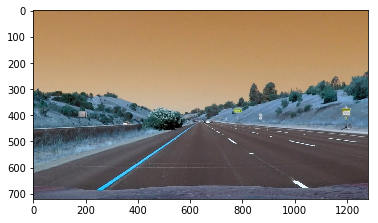

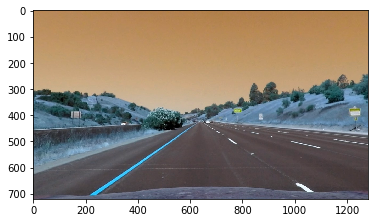

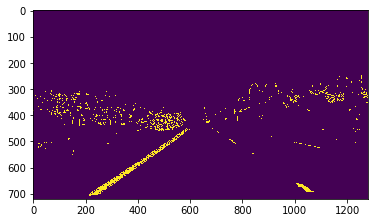

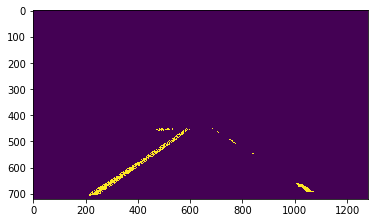

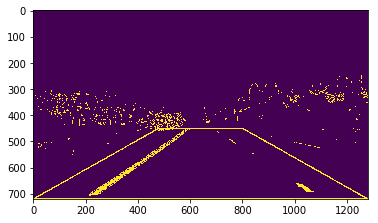

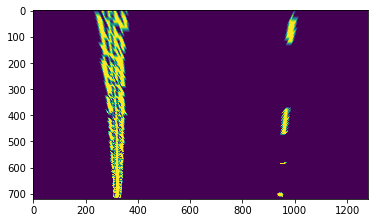

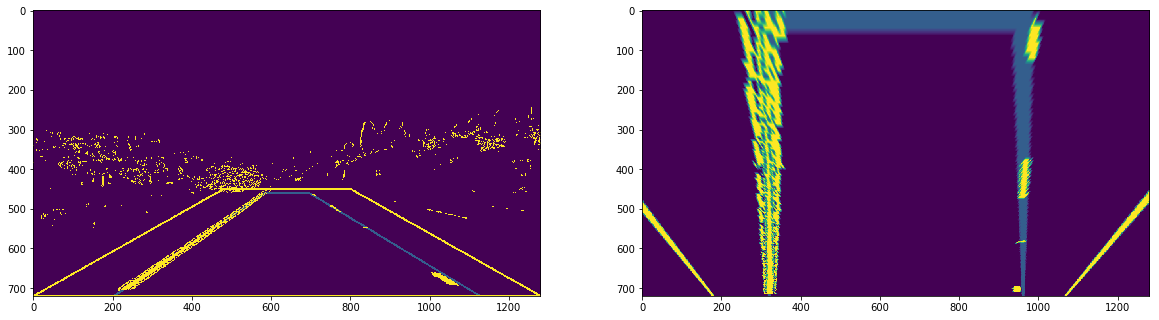

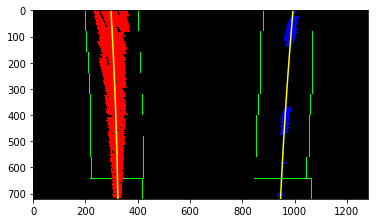

In [15]:
test_images = glob.glob('test_images_report/*.jpg')

pipe = Pipeline()
pipe.calibrate()

for img_file in test_images:
    img = cv2.imread(img_file)
    processed_image = pipe.pipeline(img, plot_enabled=True)
    
    plt.figure()
    plt.imshow(processed_image)   
    cv2.imwrite('final.png', processed_image)


cv2.destroyAllWindows()


In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip2 = VideoFileClip('project_video.mp4')
output_clip = 'project_video_result.mp4'
processed_clip = clip2.fl_image(pipe.pipeline)

%time processed_clip.write_videofile(output_clip, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4


[MoviePy] Writing video project_video_result.mp4


  0%|                                                                                                                                                                                                         | 0/1261 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                | 1/1261 [00:00<02:57,  7.10it/s]

  0%|▎                                                                                                                                                                                                | 2/1261 [00:00<03:23,  6.18it/s]

  0%|▍                                                                                                                                                                                                | 3/1261 [00:00<03:20,  6.27it/s]

  0%|▌                                                                                                                                                                                                | 4/1261 [00:00<03:21,  6.23it/s]

  0%|▊                                                                                                                                                                                                | 5/1261 [00:00<03:29,  6.01it/s]

  0%|▉                                                                                                                                                                                                | 6/1261 [00:01<03:31,  5.93it/s]

  1%|█                                                                                                                                                                                                | 7/1261 [00:01<03:40,  5.68it/s]

  1%|█▏                                                                                                                                                                                               | 8/1261 [00:01<03:40,  5.67it/s]

  1%|█▍                                                                                                                                                                                               | 9/1261 [00:01<03:35,  5.81it/s]

  1%|█▌                                                                                                                                                                                              | 10/1261 [00:01<03:36,  5.79it/s]

  1%|█▋                                                                                                                                                                                              | 11/1261 [00:01<03:37,  5.74it/s]

  1%|█▊                                                                                                                                                                                              | 12/1261 [00:02<03:34,  5.81it/s]

  1%|█▉                                                                                                                                                                                              | 13/1261 [00:02<03:31,  5.90it/s]

  1%|██▏                                                                                                                                                                                             | 14/1261 [00:02<03:29,  5.94it/s]

  1%|██▎                                                                                                                                                                                             | 15/1261 [00:02<03:32,  5.87it/s]

  1%|██▍                                                                                                                                                                                             | 16/1261 [00:02<03:30,  5.91it/s]

  1%|██▌                                                                                                                                                                                             | 17/1261 [00:02<03:29,  5.93it/s]

  1%|██▋                                                                                                                                                                                             | 18/1261 [00:03<03:29,  5.94it/s]

  2%|██▉                                                                                                                                                                                             | 19/1261 [00:03<03:28,  5.97it/s]

  2%|███                                                                                                                                                                                             | 20/1261 [00:03<03:26,  6.00it/s]

  2%|███▏                                                                                                                                                                                            | 21/1261 [00:03<03:26,  6.00it/s]

  2%|███▎                                                                                                                                                                                            | 22/1261 [00:03<03:25,  6.02it/s]

  2%|███▌                                                                                                                                                                                            | 23/1261 [00:03<03:25,  6.02it/s]

  2%|███▋                                                                                                                                                                                            | 24/1261 [00:04<03:26,  5.99it/s]

  2%|███▊                                                                                                                                                                                            | 25/1261 [00:04<03:25,  6.02it/s]

  2%|███▉                                                                                                                                                                                            | 26/1261 [00:04<03:25,  6.02it/s]

  2%|████                                                                                                                                                                                            | 27/1261 [00:04<03:24,  6.02it/s]

  2%|████▎                                                                                                                                                                                           | 28/1261 [00:04<03:25,  6.00it/s]

  2%|████▍                                                                                                                                                                                           | 29/1261 [00:04<03:25,  6.00it/s]

  2%|████▌                                                                                                                                                                                           | 30/1261 [00:05<03:25,  5.99it/s]

  2%|████▋                                                                                                                                                                                           | 31/1261 [00:05<03:25,  5.98it/s]

  3%|████▊                                                                                                                                                                                           | 32/1261 [00:05<03:25,  5.98it/s]

  3%|█████                                                                                                                                                                                           | 33/1261 [00:05<03:25,  5.96it/s]

  3%|█████▏                                                                                                                                                                                          | 34/1261 [00:05<03:25,  5.97it/s]

  3%|█████▎                                                                                                                                                                                          | 35/1261 [00:05<03:24,  5.98it/s]

  3%|█████▍                                                                                                                                                                                          | 36/1261 [00:06<03:24,  5.98it/s]

  3%|█████▋                                                                                                                                                                                          | 37/1261 [00:06<03:23,  6.00it/s]

  3%|█████▊                                                                                                                                                                                          | 38/1261 [00:06<03:23,  6.02it/s]

  3%|█████▉                                                                                                                                                                                          | 39/1261 [00:06<03:22,  6.03it/s]

  3%|██████                                                                                                                                                                                          | 40/1261 [00:06<03:22,  6.03it/s]

  3%|██████▏                                                                                                                                                                                         | 41/1261 [00:06<03:21,  6.05it/s]

  3%|██████▍                                                                                                                                                                                         | 42/1261 [00:06<03:20,  6.07it/s]

  3%|██████▌                                                                                                                                                                                         | 43/1261 [00:07<03:20,  6.08it/s]

  3%|██████▋                                                                                                                                                                                         | 44/1261 [00:07<03:19,  6.09it/s]

  4%|██████▊                                                                                                                                                                                         | 45/1261 [00:07<03:19,  6.11it/s]

  4%|███████                                                                                                                                                                                         | 46/1261 [00:07<03:18,  6.12it/s]

  4%|███████▏                                                                                                                                                                                        | 47/1261 [00:07<03:18,  6.12it/s]

  4%|███████▎                                                                                                                                                                                        | 48/1261 [00:07<03:17,  6.13it/s]

  4%|███████▍                                                                                                                                                                                        | 49/1261 [00:07<03:17,  6.14it/s]

  4%|███████▌                                                                                                                                                                                        | 50/1261 [00:08<03:17,  6.13it/s]

  4%|███████▊                                                                                                                                                                                        | 51/1261 [00:08<03:16,  6.14it/s]

  4%|███████▉                                                                                                                                                                                        | 52/1261 [00:08<03:16,  6.16it/s]

  4%|████████                                                                                                                                                                                        | 53/1261 [00:08<03:15,  6.17it/s]

  4%|████████▏                                                                                                                                                                                       | 54/1261 [00:08<03:15,  6.18it/s]

  4%|████████▎                                                                                                                                                                                       | 55/1261 [00:08<03:15,  6.18it/s]

  4%|████████▌                                                                                                                                                                                       | 56/1261 [00:09<03:14,  6.20it/s]

  5%|████████▋                                                                                                                                                                                       | 57/1261 [00:09<03:14,  6.20it/s]

  5%|████████▊                                                                                                                                                                                       | 58/1261 [00:09<03:13,  6.20it/s]

  5%|████████▉                                                                                                                                                                                       | 59/1261 [00:09<03:13,  6.21it/s]

  5%|█████████▏                                                                                                                                                                                      | 60/1261 [00:09<03:13,  6.21it/s]

  5%|█████████▎                                                                                                                                                                                      | 61/1261 [00:09<03:13,  6.21it/s]

  5%|█████████▍                                                                                                                                                                                      | 62/1261 [00:09<03:13,  6.21it/s]

  5%|█████████▌                                                                                                                                                                                      | 63/1261 [00:10<03:13,  6.19it/s]

  5%|█████████▋                                                                                                                                                                                      | 64/1261 [00:10<03:13,  6.18it/s]

  5%|█████████▉                                                                                                                                                                                      | 65/1261 [00:10<03:13,  6.18it/s]

  5%|██████████                                                                                                                                                                                      | 66/1261 [00:10<03:14,  6.16it/s]

  5%|██████████▏                                                                                                                                                                                     | 67/1261 [00:10<03:13,  6.16it/s]

  5%|██████████▎                                                                                                                                                                                     | 68/1261 [00:11<03:13,  6.17it/s]

  5%|██████████▌                                                                                                                                                                                     | 69/1261 [00:11<03:13,  6.17it/s]

  6%|██████████▋                                                                                                                                                                                     | 70/1261 [00:11<03:12,  6.18it/s]

  6%|██████████▊                                                                                                                                                                                     | 71/1261 [00:11<03:12,  6.18it/s]

  6%|██████████▉                                                                                                                                                                                     | 72/1261 [00:11<03:12,  6.19it/s]

  6%|███████████                                                                                                                                                                                     | 73/1261 [00:11<03:11,  6.20it/s]

  6%|███████████▎                                                                                                                                                                                    | 74/1261 [00:11<03:11,  6.20it/s]

  6%|███████████▍                                                                                                                                                                                    | 75/1261 [00:12<03:11,  6.21it/s]

  6%|███████████▌                                                                                                                                                                                    | 76/1261 [00:12<03:10,  6.21it/s]

  6%|███████████▋                                                                                                                                                                                    | 77/1261 [00:12<03:10,  6.21it/s]

  6%|███████████▉                                                                                                                                                                                    | 78/1261 [00:12<03:10,  6.22it/s]

  6%|████████████                                                                                                                                                                                    | 79/1261 [00:12<03:10,  6.22it/s]

  6%|████████████▏                                                                                                                                                                                   | 80/1261 [00:12<03:09,  6.22it/s]

  6%|████████████▎                                                                                                                                                                                   | 81/1261 [00:13<03:09,  6.23it/s]

  7%|████████████▍                                                                                                                                                                                   | 82/1261 [00:13<03:09,  6.23it/s]

  7%|████████████▋                                                                                                                                                                                   | 83/1261 [00:13<03:09,  6.23it/s]

  7%|████████████▊                                                                                                                                                                                   | 84/1261 [00:13<03:09,  6.22it/s]

  7%|████████████▉                                                                                                                                                                                   | 85/1261 [00:13<03:08,  6.22it/s]

  7%|█████████████                                                                                                                                                                                   | 86/1261 [00:13<03:08,  6.23it/s]

  7%|█████████████▏                                                                                                                                                                                  | 87/1261 [00:13<03:08,  6.24it/s]

  7%|█████████████▍                                                                                                                                                                                  | 88/1261 [00:14<03:07,  6.25it/s]

  7%|█████████████▌                                                                                                                                                                                  | 89/1261 [00:14<03:07,  6.25it/s]

  7%|█████████████▋                                                                                                                                                                                  | 90/1261 [00:14<03:07,  6.25it/s]

  7%|█████████████▊                                                                                                                                                                                  | 91/1261 [00:14<03:07,  6.25it/s]

  7%|██████████████                                                                                                                                                                                  | 92/1261 [00:14<03:06,  6.26it/s]

  7%|██████████████▏                                                                                                                                                                                 | 93/1261 [00:14<03:06,  6.26it/s]

  7%|██████████████▎                                                                                                                                                                                 | 94/1261 [00:15<03:06,  6.26it/s]

  8%|██████████████▍                                                                                                                                                                                 | 95/1261 [00:15<03:06,  6.26it/s]

  8%|██████████████▌                                                                                                                                                                                 | 96/1261 [00:15<03:05,  6.27it/s]

  8%|██████████████▊                                                                                                                                                                                 | 97/1261 [00:15<03:05,  6.27it/s]

  8%|██████████████▉                                                                                                                                                                                 | 98/1261 [00:15<03:05,  6.27it/s]

  8%|███████████████                                                                                                                                                                                 | 99/1261 [00:15<03:05,  6.27it/s]

  8%|███████████████▏                                                                                                                                                                               | 100/1261 [00:15<03:05,  6.27it/s]

  8%|███████████████▎                                                                                                                                                                               | 101/1261 [00:16<03:04,  6.27it/s]

  8%|███████████████▍                                                                                                                                                                               | 102/1261 [00:16<03:04,  6.28it/s]

  8%|███████████████▌                                                                                                                                                                               | 103/1261 [00:16<03:04,  6.28it/s]

  8%|███████████████▊                                                                                                                                                                               | 104/1261 [00:16<03:03,  6.29it/s]

  8%|███████████████▉                                                                                                                                                                               | 105/1261 [00:16<03:03,  6.29it/s]

  8%|████████████████                                                                                                                                                                               | 106/1261 [00:16<03:03,  6.30it/s]

  8%|████████████████▏                                                                                                                                                                              | 107/1261 [00:16<03:03,  6.30it/s]

  9%|████████████████▎                                                                                                                                                                              | 108/1261 [00:17<03:03,  6.30it/s]

  9%|████████████████▌                                                                                                                                                                              | 109/1261 [00:17<03:02,  6.30it/s]

  9%|████████████████▋                                                                                                                                                                              | 110/1261 [00:17<03:02,  6.30it/s]

  9%|████████████████▊                                                                                                                                                                              | 111/1261 [00:17<03:02,  6.31it/s]

  9%|████████████████▉                                                                                                                                                                              | 112/1261 [00:17<03:01,  6.31it/s]

  9%|█████████████████                                                                                                                                                                              | 113/1261 [00:17<03:01,  6.32it/s]

  9%|█████████████████▎                                                                                                                                                                             | 114/1261 [00:18<03:01,  6.32it/s]

  9%|█████████████████▍                                                                                                                                                                             | 115/1261 [00:18<03:01,  6.33it/s]

  9%|█████████████████▌                                                                                                                                                                             | 116/1261 [00:18<03:00,  6.33it/s]

  9%|█████████████████▋                                                                                                                                                                             | 117/1261 [00:18<03:00,  6.34it/s]

  9%|█████████████████▊                                                                                                                                                                             | 118/1261 [00:18<03:00,  6.34it/s]

  9%|██████████████████                                                                                                                                                                             | 119/1261 [00:18<03:00,  6.34it/s]

 10%|██████████████████▏                                                                                                                                                                            | 120/1261 [00:18<02:59,  6.35it/s]

 10%|██████████████████▎                                                                                                                                                                            | 121/1261 [00:19<02:59,  6.35it/s]

 10%|██████████████████▍                                                                                                                                                                            | 122/1261 [00:19<02:59,  6.36it/s]

 10%|██████████████████▋                                                                                                                                                                            | 123/1261 [00:19<02:58,  6.37it/s]

 10%|██████████████████▊                                                                                                                                                                            | 124/1261 [00:19<02:58,  6.37it/s]

 10%|██████████████████▉                                                                                                                                                                            | 125/1261 [00:19<02:58,  6.37it/s]

 10%|███████████████████                                                                                                                                                                            | 126/1261 [00:19<02:58,  6.37it/s]

 10%|███████████████████▏                                                                                                                                                                           | 127/1261 [00:19<02:57,  6.38it/s]

 10%|███████████████████▍                                                                                                                                                                           | 128/1261 [00:20<02:57,  6.38it/s]

 10%|███████████████████▌                                                                                                                                                                           | 129/1261 [00:20<02:57,  6.39it/s]

 10%|███████████████████▋                                                                                                                                                                           | 130/1261 [00:20<02:56,  6.39it/s]

 10%|███████████████████▊                                                                                                                                                                           | 131/1261 [00:20<02:56,  6.40it/s]

 10%|███████████████████▉                                                                                                                                                                           | 132/1261 [00:20<02:56,  6.39it/s]

 11%|████████████████████▏                                                                                                                                                                          | 133/1261 [00:20<02:56,  6.39it/s]

 11%|████████████████████▎                                                                                                                                                                          | 134/1261 [00:20<02:56,  6.40it/s]

 11%|████████████████████▍                                                                                                                                                                          | 135/1261 [00:21<02:55,  6.40it/s]

 11%|████████████████████▌                                                                                                                                                                          | 136/1261 [00:21<02:55,  6.41it/s]

 11%|████████████████████▊                                                                                                                                                                          | 137/1261 [00:21<02:55,  6.41it/s]

 11%|████████████████████▉                                                                                                                                                                          | 138/1261 [00:21<02:55,  6.42it/s]

 11%|█████████████████████                                                                                                                                                                          | 139/1261 [00:21<02:54,  6.42it/s]

 11%|█████████████████████▏                                                                                                                                                                         | 140/1261 [00:21<02:54,  6.42it/s]

 11%|█████████████████████▎                                                                                                                                                                         | 141/1261 [00:21<02:54,  6.43it/s]

 11%|█████████████████████▌                                                                                                                                                                         | 142/1261 [00:22<02:53,  6.43it/s]

 11%|█████████████████████▋                                                                                                                                                                         | 143/1261 [00:22<02:53,  6.44it/s]

 11%|█████████████████████▊                                                                                                                                                                         | 144/1261 [00:22<02:53,  6.44it/s]

 11%|█████████████████████▉                                                                                                                                                                         | 145/1261 [00:22<02:53,  6.44it/s]

 12%|██████████████████████                                                                                                                                                                         | 146/1261 [00:22<02:53,  6.44it/s]

 12%|██████████████████████▎                                                                                                                                                                        | 147/1261 [00:22<02:52,  6.44it/s]

 12%|██████████████████████▍                                                                                                                                                                        | 148/1261 [00:22<02:52,  6.45it/s]

 12%|██████████████████████▌                                                                                                                                                                        | 149/1261 [00:23<02:52,  6.45it/s]

 12%|██████████████████████▋                                                                                                                                                                        | 150/1261 [00:23<02:52,  6.45it/s]

 12%|██████████████████████▊                                                                                                                                                                        | 151/1261 [00:23<02:51,  6.46it/s]

 12%|███████████████████████                                                                                                                                                                        | 152/1261 [00:23<02:51,  6.46it/s]

 12%|███████████████████████▏                                                                                                                                                                       | 153/1261 [00:23<02:51,  6.46it/s]

 12%|███████████████████████▎                                                                                                                                                                       | 154/1261 [00:23<02:51,  6.46it/s]

 12%|███████████████████████▍                                                                                                                                                                       | 155/1261 [00:23<02:51,  6.46it/s]

 12%|███████████████████████▋                                                                                                                                                                       | 156/1261 [00:24<02:50,  6.47it/s]

 12%|███████████████████████▊                                                                                                                                                                       | 157/1261 [00:24<02:50,  6.47it/s]

 13%|███████████████████████▉                                                                                                                                                                       | 158/1261 [00:24<02:50,  6.47it/s]

 13%|████████████████████████                                                                                                                                                                       | 159/1261 [00:24<02:50,  6.46it/s]

 13%|████████████████████████▏                                                                                                                                                                      | 160/1261 [00:24<02:50,  6.46it/s]

 13%|████████████████████████▍                                                                                                                                                                      | 161/1261 [00:24<02:50,  6.47it/s]

 13%|████████████████████████▌                                                                                                                                                                      | 162/1261 [00:25<02:49,  6.47it/s]

 13%|████████████████████████▋                                                                                                                                                                      | 163/1261 [00:25<02:49,  6.47it/s]

 13%|████████████████████████▊                                                                                                                                                                      | 164/1261 [00:25<02:49,  6.48it/s]

 13%|████████████████████████▉                                                                                                                                                                      | 165/1261 [00:25<02:49,  6.48it/s]

 13%|█████████████████████████▏                                                                                                                                                                     | 166/1261 [00:25<02:48,  6.48it/s]

 13%|█████████████████████████▎                                                                                                                                                                     | 167/1261 [00:25<02:48,  6.48it/s]

 13%|█████████████████████████▍                                                                                                                                                                     | 168/1261 [00:25<02:48,  6.49it/s]

 13%|█████████████████████████▌                                                                                                                                                                     | 169/1261 [00:26<02:48,  6.49it/s]

 13%|█████████████████████████▋                                                                                                                                                                     | 170/1261 [00:26<02:48,  6.49it/s]

 14%|█████████████████████████▉                                                                                                                                                                     | 171/1261 [00:26<02:47,  6.50it/s]

 14%|██████████████████████████                                                                                                                                                                     | 172/1261 [00:26<02:47,  6.50it/s]

 14%|██████████████████████████▏                                                                                                                                                                    | 173/1261 [00:26<02:47,  6.50it/s]

 14%|██████████████████████████▎                                                                                                                                                                    | 174/1261 [00:26<02:47,  6.50it/s]

 14%|██████████████████████████▌                                                                                                                                                                    | 175/1261 [00:26<02:46,  6.50it/s]

 14%|██████████████████████████▋                                                                                                                                                                    | 176/1261 [00:27<02:46,  6.50it/s]

 14%|██████████████████████████▊                                                                                                                                                                    | 177/1261 [00:27<02:46,  6.51it/s]

 14%|██████████████████████████▉                                                                                                                                                                    | 178/1261 [00:27<02:46,  6.51it/s]

 14%|███████████████████████████                                                                                                                                                                    | 179/1261 [00:27<02:46,  6.51it/s]

 14%|███████████████████████████▎                                                                                                                                                                   | 180/1261 [00:27<02:45,  6.51it/s]

 14%|███████████████████████████▍                                                                                                                                                                   | 181/1261 [00:27<02:45,  6.52it/s]

 14%|███████████████████████████▌                                                                                                                                                                   | 182/1261 [00:27<02:45,  6.52it/s]

 15%|███████████████████████████▋                                                                                                                                                                   | 183/1261 [00:28<02:45,  6.52it/s]

 15%|███████████████████████████▊                                                                                                                                                                   | 184/1261 [00:28<02:45,  6.52it/s]

 15%|████████████████████████████                                                                                                                                                                   | 185/1261 [00:28<02:44,  6.52it/s]

 15%|████████████████████████████▏                                                                                                                                                                  | 186/1261 [00:28<02:44,  6.53it/s]

 15%|████████████████████████████▎                                                                                                                                                                  | 187/1261 [00:28<02:44,  6.53it/s]

 15%|████████████████████████████▍                                                                                                                                                                  | 188/1261 [00:28<02:44,  6.53it/s]

 15%|████████████████████████████▋                                                                                                                                                                  | 189/1261 [00:28<02:44,  6.54it/s]

 15%|████████████████████████████▊                                                                                                                                                                  | 190/1261 [00:29<02:43,  6.54it/s]

 15%|████████████████████████████▉                                                                                                                                                                  | 191/1261 [00:29<02:43,  6.54it/s]

 15%|█████████████████████████████                                                                                                                                                                  | 192/1261 [00:29<02:43,  6.54it/s]

 15%|█████████████████████████████▏                                                                                                                                                                 | 193/1261 [00:29<02:43,  6.54it/s]

 15%|█████████████████████████████▍                                                                                                                                                                 | 194/1261 [00:29<02:43,  6.54it/s]

 15%|█████████████████████████████▌                                                                                                                                                                 | 195/1261 [00:29<02:42,  6.54it/s]

 16%|█████████████████████████████▋                                                                                                                                                                 | 196/1261 [00:29<02:42,  6.55it/s]

 16%|█████████████████████████████▊                                                                                                                                                                 | 197/1261 [00:30<02:42,  6.54it/s]

 16%|█████████████████████████████▉                                                                                                                                                                 | 198/1261 [00:30<02:42,  6.54it/s]

 16%|██████████████████████████████▏                                                                                                                                                                | 199/1261 [00:30<02:42,  6.54it/s]

 16%|██████████████████████████████▎                                                                                                                                                                | 200/1261 [00:30<02:42,  6.55it/s]

 16%|██████████████████████████████▍                                                                                                                                                                | 201/1261 [00:30<02:41,  6.55it/s]

 16%|██████████████████████████████▌                                                                                                                                                                | 202/1261 [00:30<02:41,  6.55it/s]

 16%|██████████████████████████████▋                                                                                                                                                                | 203/1261 [00:30<02:41,  6.55it/s]

 16%|██████████████████████████████▉                                                                                                                                                                | 204/1261 [00:31<02:41,  6.55it/s]

 16%|███████████████████████████████                                                                                                                                                                | 205/1261 [00:31<02:41,  6.55it/s]

 16%|███████████████████████████████▏                                                                                                                                                               | 206/1261 [00:31<02:40,  6.55it/s]

 16%|███████████████████████████████▎                                                                                                                                                               | 207/1261 [00:31<02:40,  6.56it/s]

 16%|███████████████████████████████▌                                                                                                                                                               | 208/1261 [00:31<02:40,  6.55it/s]

 17%|███████████████████████████████▋                                                                                                                                                               | 209/1261 [00:31<02:40,  6.55it/s]

 17%|███████████████████████████████▊                                                                                                                                                               | 210/1261 [00:32<02:40,  6.56it/s]

 17%|███████████████████████████████▉                                                                                                                                                               | 211/1261 [00:32<02:40,  6.56it/s]

 17%|████████████████████████████████                                                                                                                                                               | 212/1261 [00:32<02:39,  6.56it/s]

 17%|████████████████████████████████▎                                                                                                                                                              | 213/1261 [00:32<02:39,  6.56it/s]

 17%|████████████████████████████████▍                                                                                                                                                              | 214/1261 [00:32<02:39,  6.57it/s]

 17%|████████████████████████████████▌                                                                                                                                                              | 215/1261 [00:32<02:39,  6.57it/s]

 17%|████████████████████████████████▋                                                                                                                                                              | 216/1261 [00:32<02:39,  6.57it/s]

 17%|████████████████████████████████▊                                                                                                                                                              | 217/1261 [00:33<02:38,  6.57it/s]

 17%|█████████████████████████████████                                                                                                                                                              | 218/1261 [00:33<02:38,  6.57it/s]

 17%|█████████████████████████████████▏                                                                                                                                                             | 219/1261 [00:33<02:38,  6.57it/s]

 17%|█████████████████████████████████▎                                                                                                                                                             | 220/1261 [00:33<02:38,  6.57it/s]

 18%|█████████████████████████████████▍                                                                                                                                                             | 221/1261 [00:33<02:38,  6.58it/s]

 18%|█████████████████████████████████▋                                                                                                                                                             | 222/1261 [00:33<02:37,  6.58it/s]

 18%|█████████████████████████████████▊                                                                                                                                                             | 223/1261 [00:33<02:37,  6.58it/s]

 18%|█████████████████████████████████▉                                                                                                                                                             | 224/1261 [00:34<02:37,  6.58it/s]

 18%|██████████████████████████████████                                                                                                                                                             | 225/1261 [00:34<02:37,  6.58it/s]

 18%|██████████████████████████████████▏                                                                                                                                                            | 226/1261 [00:34<02:37,  6.58it/s]

 18%|██████████████████████████████████▍                                                                                                                                                            | 227/1261 [00:34<02:37,  6.58it/s]

 18%|██████████████████████████████████▌                                                                                                                                                            | 228/1261 [00:34<02:36,  6.58it/s]

 18%|██████████████████████████████████▋                                                                                                                                                            | 229/1261 [00:34<02:36,  6.58it/s]

 18%|██████████████████████████████████▊                                                                                                                                                            | 230/1261 [00:34<02:36,  6.59it/s]

 18%|██████████████████████████████████▉                                                                                                                                                            | 231/1261 [00:35<02:36,  6.59it/s]

 18%|███████████████████████████████████▏                                                                                                                                                           | 232/1261 [00:35<02:36,  6.59it/s]

 18%|███████████████████████████████████▎                                                                                                                                                           | 233/1261 [00:35<02:35,  6.59it/s]

 19%|███████████████████████████████████▍                                                                                                                                                           | 234/1261 [00:35<02:35,  6.59it/s]

 19%|███████████████████████████████████▌                                                                                                                                                           | 235/1261 [00:35<02:35,  6.59it/s]

 19%|███████████████████████████████████▋                                                                                                                                                           | 236/1261 [00:35<02:35,  6.60it/s]

 19%|███████████████████████████████████▉                                                                                                                                                           | 237/1261 [00:35<02:35,  6.60it/s]

 19%|████████████████████████████████████                                                                                                                                                           | 238/1261 [00:36<02:35,  6.60it/s]

 19%|████████████████████████████████████▏                                                                                                                                                          | 239/1261 [00:36<02:34,  6.60it/s]

 19%|████████████████████████████████████▎                                                                                                                                                          | 240/1261 [00:36<02:34,  6.60it/s]

 19%|████████████████████████████████████▌                                                                                                                                                          | 241/1261 [00:36<02:34,  6.60it/s]

 19%|████████████████████████████████████▋                                                                                                                                                          | 242/1261 [00:36<02:34,  6.60it/s]

 19%|████████████████████████████████████▊                                                                                                                                                          | 243/1261 [00:36<02:34,  6.60it/s]

 19%|████████████████████████████████████▉                                                                                                                                                          | 244/1261 [00:36<02:34,  6.60it/s]

 19%|█████████████████████████████████████                                                                                                                                                          | 245/1261 [00:37<02:33,  6.60it/s]

 20%|█████████████████████████████████████▎                                                                                                                                                         | 246/1261 [00:37<02:33,  6.60it/s]

 20%|█████████████████████████████████████▍                                                                                                                                                         | 247/1261 [00:37<02:33,  6.60it/s]

 20%|█████████████████████████████████████▌                                                                                                                                                         | 248/1261 [00:37<02:33,  6.60it/s]

 20%|█████████████████████████████████████▋                                                                                                                                                         | 249/1261 [00:37<02:33,  6.60it/s]

 20%|█████████████████████████████████████▊                                                                                                                                                         | 250/1261 [00:37<02:33,  6.60it/s]

 20%|██████████████████████████████████████                                                                                                                                                         | 251/1261 [00:38<02:32,  6.60it/s]

 20%|██████████████████████████████████████▏                                                                                                                                                        | 252/1261 [00:38<02:32,  6.60it/s]

 20%|██████████████████████████████████████▎                                                                                                                                                        | 253/1261 [00:38<02:32,  6.60it/s]

 20%|██████████████████████████████████████▍                                                                                                                                                        | 254/1261 [00:38<02:32,  6.60it/s]

 20%|██████████████████████████████████████▌                                                                                                                                                        | 255/1261 [00:38<02:32,  6.60it/s]

 20%|██████████████████████████████████████▊                                                                                                                                                        | 256/1261 [00:38<02:32,  6.59it/s]

 20%|██████████████████████████████████████▉                                                                                                                                                        | 257/1261 [00:38<02:32,  6.60it/s]

 20%|███████████████████████████████████████                                                                                                                                                        | 258/1261 [00:39<02:32,  6.60it/s]

 21%|███████████████████████████████████████▏                                                                                                                                                       | 259/1261 [00:39<02:31,  6.60it/s]

 21%|███████████████████████████████████████▍                                                                                                                                                       | 260/1261 [00:39<02:31,  6.60it/s]

 21%|███████████████████████████████████████▌                                                                                                                                                       | 261/1261 [00:39<02:31,  6.60it/s]

 21%|███████████████████████████████████████▋                                                                                                                                                       | 262/1261 [00:39<02:31,  6.60it/s]

 21%|███████████████████████████████████████▊                                                                                                                                                       | 263/1261 [00:39<02:31,  6.60it/s]

 21%|███████████████████████████████████████▉                                                                                                                                                       | 264/1261 [00:39<02:30,  6.60it/s]

 21%|████████████████████████████████████████▏                                                                                                                                                      | 265/1261 [00:40<02:30,  6.61it/s]

 21%|████████████████████████████████████████▎                                                                                                                                                      | 266/1261 [00:40<02:30,  6.61it/s]

 21%|████████████████████████████████████████▍                                                                                                                                                      | 267/1261 [00:40<02:30,  6.61it/s]

 21%|████████████████████████████████████████▌                                                                                                                                                      | 268/1261 [00:40<02:30,  6.61it/s]

 21%|████████████████████████████████████████▋                                                                                                                                                      | 269/1261 [00:40<02:30,  6.61it/s]

 21%|████████████████████████████████████████▉                                                                                                                                                      | 270/1261 [00:40<02:29,  6.61it/s]

 21%|█████████████████████████████████████████                                                                                                                                                      | 271/1261 [00:40<02:29,  6.61it/s]

 22%|█████████████████████████████████████████▏                                                                                                                                                     | 272/1261 [00:41<02:29,  6.61it/s]

 22%|█████████████████████████████████████████▎                                                                                                                                                     | 273/1261 [00:41<02:29,  6.61it/s]

 22%|█████████████████████████████████████████▌                                                                                                                                                     | 274/1261 [00:41<02:29,  6.61it/s]

 22%|█████████████████████████████████████████▋                                                                                                                                                     | 275/1261 [00:41<02:29,  6.61it/s]

 22%|█████████████████████████████████████████▊                                                                                                                                                     | 276/1261 [00:41<02:28,  6.61it/s]

 22%|█████████████████████████████████████████▉                                                                                                                                                     | 277/1261 [00:41<02:28,  6.61it/s]

 22%|██████████████████████████████████████████                                                                                                                                                     | 278/1261 [00:42<02:28,  6.62it/s]

 22%|██████████████████████████████████████████▎                                                                                                                                                    | 279/1261 [00:42<02:28,  6.62it/s]

 22%|██████████████████████████████████████████▍                                                                                                                                                    | 280/1261 [00:42<02:28,  6.62it/s]

 22%|██████████████████████████████████████████▌                                                                                                                                                    | 281/1261 [00:42<02:28,  6.62it/s]

 22%|██████████████████████████████████████████▋                                                                                                                                                    | 282/1261 [00:42<02:27,  6.62it/s]

 22%|██████████████████████████████████████████▊                                                                                                                                                    | 283/1261 [00:42<02:27,  6.62it/s]

 23%|███████████████████████████████████████████                                                                                                                                                    | 284/1261 [00:42<02:27,  6.62it/s]

 23%|███████████████████████████████████████████▏                                                                                                                                                   | 285/1261 [00:43<02:27,  6.62it/s]

 23%|███████████████████████████████████████████▎                                                                                                                                                   | 286/1261 [00:43<02:27,  6.62it/s]

 23%|███████████████████████████████████████████▍                                                                                                                                                   | 287/1261 [00:43<02:27,  6.62it/s]

 23%|███████████████████████████████████████████▌                                                                                                                                                   | 288/1261 [00:43<02:26,  6.62it/s]

 23%|███████████████████████████████████████████▊                                                                                                                                                   | 289/1261 [00:43<02:26,  6.62it/s]

 23%|███████████████████████████████████████████▉                                                                                                                                                   | 290/1261 [00:43<02:26,  6.63it/s]

 23%|████████████████████████████████████████████                                                                                                                                                   | 291/1261 [00:43<02:26,  6.63it/s]

 23%|████████████████████████████████████████████▏                                                                                                                                                  | 292/1261 [00:44<02:26,  6.63it/s]

 23%|████████████████████████████████████████████▍                                                                                                                                                  | 293/1261 [00:44<02:26,  6.63it/s]

 23%|████████████████████████████████████████████▌                                                                                                                                                  | 294/1261 [00:44<02:25,  6.63it/s]

 23%|████████████████████████████████████████████▋                                                                                                                                                  | 295/1261 [00:44<02:25,  6.63it/s]

 23%|████████████████████████████████████████████▊                                                                                                                                                  | 296/1261 [00:44<02:25,  6.63it/s]

 24%|████████████████████████████████████████████▉                                                                                                                                                  | 297/1261 [00:44<02:25,  6.63it/s]

 24%|█████████████████████████████████████████████▏                                                                                                                                                 | 298/1261 [00:44<02:25,  6.63it/s]

 24%|█████████████████████████████████████████████▎                                                                                                                                                 | 299/1261 [00:45<02:25,  6.63it/s]

 24%|█████████████████████████████████████████████▍                                                                                                                                                 | 300/1261 [00:45<02:24,  6.63it/s]

 24%|█████████████████████████████████████████████▌                                                                                                                                                 | 301/1261 [00:45<02:24,  6.63it/s]

 24%|█████████████████████████████████████████████▋                                                                                                                                                 | 302/1261 [00:45<02:24,  6.64it/s]

 24%|█████████████████████████████████████████████▉                                                                                                                                                 | 303/1261 [00:45<02:24,  6.64it/s]

 24%|██████████████████████████████████████████████                                                                                                                                                 | 304/1261 [00:45<02:24,  6.64it/s]

 24%|██████████████████████████████████████████████▏                                                                                                                                                | 305/1261 [00:45<02:24,  6.64it/s]

 24%|██████████████████████████████████████████████▎                                                                                                                                                | 306/1261 [00:46<02:23,  6.64it/s]

 24%|██████████████████████████████████████████████▌                                                                                                                                                | 307/1261 [00:46<02:23,  6.64it/s]

 24%|██████████████████████████████████████████████▋                                                                                                                                                | 308/1261 [00:46<02:23,  6.64it/s]

 25%|██████████████████████████████████████████████▊                                                                                                                                                | 309/1261 [00:46<02:23,  6.64it/s]

 25%|██████████████████████████████████████████████▉                                                                                                                                                | 310/1261 [00:46<02:23,  6.64it/s]

 25%|███████████████████████████████████████████████                                                                                                                                                | 311/1261 [00:46<02:23,  6.64it/s]

 25%|███████████████████████████████████████████████▎                                                                                                                                               | 312/1261 [00:46<02:22,  6.64it/s]

 25%|███████████████████████████████████████████████▍                                                                                                                                               | 313/1261 [00:47<02:22,  6.64it/s]

 25%|███████████████████████████████████████████████▌                                                                                                                                               | 314/1261 [00:47<02:22,  6.64it/s]

 25%|███████████████████████████████████████████████▋                                                                                                                                               | 315/1261 [00:47<02:22,  6.64it/s]

 25%|███████████████████████████████████████████████▊                                                                                                                                               | 316/1261 [00:47<02:22,  6.64it/s]

 25%|████████████████████████████████████████████████                                                                                                                                               | 317/1261 [00:47<02:22,  6.64it/s]

 25%|████████████████████████████████████████████████▏                                                                                                                                              | 318/1261 [00:47<02:21,  6.65it/s]

 25%|████████████████████████████████████████████████▎                                                                                                                                              | 319/1261 [00:47<02:21,  6.65it/s]

 25%|████████████████████████████████████████████████▍                                                                                                                                              | 320/1261 [00:48<02:21,  6.65it/s]

 25%|████████████████████████████████████████████████▌                                                                                                                                              | 321/1261 [00:48<02:21,  6.65it/s]

 26%|████████████████████████████████████████████████▊                                                                                                                                              | 322/1261 [00:48<02:21,  6.65it/s]

 26%|████████████████████████████████████████████████▉                                                                                                                                              | 323/1261 [00:48<02:21,  6.65it/s]

 26%|█████████████████████████████████████████████████                                                                                                                                              | 324/1261 [00:48<02:20,  6.65it/s]

 26%|█████████████████████████████████████████████████▏                                                                                                                                             | 325/1261 [00:48<02:20,  6.65it/s]

 26%|█████████████████████████████████████████████████▍                                                                                                                                             | 326/1261 [00:49<02:20,  6.65it/s]

 26%|█████████████████████████████████████████████████▌                                                                                                                                             | 327/1261 [00:49<02:20,  6.65it/s]

 26%|█████████████████████████████████████████████████▋                                                                                                                                             | 328/1261 [00:49<02:20,  6.65it/s]

 26%|█████████████████████████████████████████████████▊                                                                                                                                             | 329/1261 [00:49<02:20,  6.65it/s]

 26%|█████████████████████████████████████████████████▉                                                                                                                                             | 330/1261 [00:49<02:19,  6.65it/s]

 26%|██████████████████████████████████████████████████▏                                                                                                                                            | 331/1261 [00:49<02:19,  6.65it/s]

 26%|██████████████████████████████████████████████████▎                                                                                                                                            | 332/1261 [00:49<02:19,  6.65it/s]

 26%|██████████████████████████████████████████████████▍                                                                                                                                            | 333/1261 [00:50<02:19,  6.65it/s]

 26%|██████████████████████████████████████████████████▌                                                                                                                                            | 334/1261 [00:50<02:19,  6.65it/s]

 27%|██████████████████████████████████████████████████▋                                                                                                                                            | 335/1261 [00:50<02:19,  6.65it/s]

 27%|██████████████████████████████████████████████████▉                                                                                                                                            | 336/1261 [00:50<02:19,  6.65it/s]

 27%|███████████████████████████████████████████████████                                                                                                                                            | 337/1261 [00:50<02:18,  6.65it/s]

 27%|███████████████████████████████████████████████████▏                                                                                                                                           | 338/1261 [00:50<02:18,  6.65it/s]

 27%|███████████████████████████████████████████████████▎                                                                                                                                           | 339/1261 [00:50<02:18,  6.65it/s]

 27%|███████████████████████████████████████████████████▍                                                                                                                                           | 340/1261 [00:51<02:18,  6.66it/s]

 27%|███████████████████████████████████████████████████▋                                                                                                                                           | 341/1261 [00:51<02:18,  6.66it/s]

 27%|███████████████████████████████████████████████████▊                                                                                                                                           | 342/1261 [00:51<02:18,  6.66it/s]

 27%|███████████████████████████████████████████████████▉                                                                                                                                           | 343/1261 [00:51<02:17,  6.66it/s]

 27%|████████████████████████████████████████████████████                                                                                                                                           | 344/1261 [00:51<02:17,  6.66it/s]

 27%|████████████████████████████████████████████████████▎                                                                                                                                          | 345/1261 [00:51<02:17,  6.66it/s]

 27%|████████████████████████████████████████████████████▍                                                                                                                                          | 346/1261 [00:51<02:17,  6.66it/s]

 28%|████████████████████████████████████████████████████▌                                                                                                                                          | 347/1261 [00:52<02:17,  6.66it/s]

 28%|████████████████████████████████████████████████████▋                                                                                                                                          | 348/1261 [00:52<02:17,  6.66it/s]

 28%|████████████████████████████████████████████████████▊                                                                                                                                          | 349/1261 [00:52<02:16,  6.66it/s]

 28%|█████████████████████████████████████████████████████                                                                                                                                          | 350/1261 [00:52<02:16,  6.66it/s]

 28%|█████████████████████████████████████████████████████▏                                                                                                                                         | 351/1261 [00:52<02:16,  6.66it/s]

 28%|█████████████████████████████████████████████████████▎                                                                                                                                         | 352/1261 [00:52<02:16,  6.66it/s]

 28%|█████████████████████████████████████████████████████▍                                                                                                                                         | 353/1261 [00:52<02:16,  6.66it/s]

 28%|█████████████████████████████████████████████████████▌                                                                                                                                         | 354/1261 [00:53<02:16,  6.66it/s]

 28%|█████████████████████████████████████████████████████▊                                                                                                                                         | 355/1261 [00:53<02:15,  6.66it/s]

 28%|█████████████████████████████████████████████████████▉                                                                                                                                         | 356/1261 [00:53<02:15,  6.66it/s]

 28%|██████████████████████████████████████████████████████                                                                                                                                         | 357/1261 [00:53<02:15,  6.66it/s]

 28%|██████████████████████████████████████████████████████▏                                                                                                                                        | 358/1261 [00:53<02:15,  6.66it/s]

 28%|██████████████████████████████████████████████████████▍                                                                                                                                        | 359/1261 [00:53<02:15,  6.66it/s]

 29%|██████████████████████████████████████████████████████▌                                                                                                                                        | 360/1261 [00:54<02:15,  6.66it/s]

 29%|██████████████████████████████████████████████████████▋                                                                                                                                        | 361/1261 [00:54<02:15,  6.66it/s]

 29%|██████████████████████████████████████████████████████▊                                                                                                                                        | 362/1261 [00:54<02:14,  6.66it/s]

 29%|██████████████████████████████████████████████████████▉                                                                                                                                        | 363/1261 [00:54<02:14,  6.67it/s]

 29%|███████████████████████████████████████████████████████▏                                                                                                                                       | 364/1261 [00:54<02:14,  6.66it/s]

 29%|███████████████████████████████████████████████████████▎                                                                                                                                       | 365/1261 [00:54<02:14,  6.67it/s]

 29%|███████████████████████████████████████████████████████▍                                                                                                                                       | 366/1261 [00:54<02:14,  6.67it/s]

 29%|███████████████████████████████████████████████████████▌                                                                                                                                       | 367/1261 [00:55<02:14,  6.67it/s]

 29%|███████████████████████████████████████████████████████▋                                                                                                                                       | 368/1261 [00:55<02:13,  6.67it/s]

 29%|███████████████████████████████████████████████████████▉                                                                                                                                       | 369/1261 [00:55<02:13,  6.67it/s]

 29%|████████████████████████████████████████████████████████                                                                                                                                       | 370/1261 [00:55<02:13,  6.67it/s]

 29%|████████████████████████████████████████████████████████▏                                                                                                                                      | 371/1261 [00:55<02:13,  6.67it/s]

 30%|████████████████████████████████████████████████████████▎                                                                                                                                      | 372/1261 [00:55<02:13,  6.67it/s]

 30%|████████████████████████████████████████████████████████▍                                                                                                                                      | 373/1261 [00:55<02:13,  6.67it/s]

 30%|████████████████████████████████████████████████████████▋                                                                                                                                      | 374/1261 [00:56<02:13,  6.67it/s]

 30%|████████████████████████████████████████████████████████▊                                                                                                                                      | 375/1261 [00:56<02:12,  6.67it/s]

 30%|████████████████████████████████████████████████████████▉                                                                                                                                      | 376/1261 [00:56<02:12,  6.67it/s]

 30%|█████████████████████████████████████████████████████████                                                                                                                                      | 377/1261 [00:56<02:12,  6.67it/s]

 30%|█████████████████████████████████████████████████████████▎                                                                                                                                     | 378/1261 [00:56<02:12,  6.67it/s]

 30%|█████████████████████████████████████████████████████████▍                                                                                                                                     | 379/1261 [00:56<02:12,  6.67it/s]

 30%|█████████████████████████████████████████████████████████▌                                                                                                                                     | 380/1261 [00:56<02:12,  6.67it/s]

 30%|█████████████████████████████████████████████████████████▋                                                                                                                                     | 381/1261 [00:57<02:11,  6.67it/s]

 30%|█████████████████████████████████████████████████████████▊                                                                                                                                     | 382/1261 [00:57<02:11,  6.67it/s]

 30%|██████████████████████████████████████████████████████████                                                                                                                                     | 383/1261 [00:57<02:11,  6.67it/s]

 30%|██████████████████████████████████████████████████████████▏                                                                                                                                    | 384/1261 [00:57<02:11,  6.67it/s]

 31%|██████████████████████████████████████████████████████████▎                                                                                                                                    | 385/1261 [00:57<02:11,  6.67it/s]

 31%|██████████████████████████████████████████████████████████▍                                                                                                                                    | 386/1261 [00:57<02:11,  6.67it/s]

 31%|██████████████████████████████████████████████████████████▌                                                                                                                                    | 387/1261 [00:58<02:11,  6.67it/s]

 31%|██████████████████████████████████████████████████████████▊                                                                                                                                    | 388/1261 [00:58<02:10,  6.67it/s]

 31%|██████████████████████████████████████████████████████████▉                                                                                                                                    | 389/1261 [00:58<02:10,  6.67it/s]

 31%|███████████████████████████████████████████████████████████                                                                                                                                    | 390/1261 [00:58<02:10,  6.67it/s]

 31%|███████████████████████████████████████████████████████████▏                                                                                                                                   | 391/1261 [00:58<02:10,  6.67it/s]

 31%|███████████████████████████████████████████████████████████▍                                                                                                                                   | 392/1261 [00:58<02:10,  6.67it/s]

 31%|███████████████████████████████████████████████████████████▌                                                                                                                                   | 393/1261 [00:58<02:10,  6.67it/s]

 31%|███████████████████████████████████████████████████████████▋                                                                                                                                   | 394/1261 [00:59<02:10,  6.67it/s]

 31%|███████████████████████████████████████████████████████████▊                                                                                                                                   | 395/1261 [00:59<02:09,  6.67it/s]

 31%|███████████████████████████████████████████████████████████▉                                                                                                                                   | 396/1261 [00:59<02:09,  6.67it/s]

 31%|████████████████████████████████████████████████████████████▏                                                                                                                                  | 397/1261 [00:59<02:09,  6.67it/s]

 32%|████████████████████████████████████████████████████████████▎                                                                                                                                  | 398/1261 [00:59<02:09,  6.67it/s]

 32%|████████████████████████████████████████████████████████████▍                                                                                                                                  | 399/1261 [00:59<02:09,  6.67it/s]

 32%|████████████████████████████████████████████████████████████▌                                                                                                                                  | 400/1261 [00:59<02:09,  6.67it/s]

 32%|████████████████████████████████████████████████████████████▋                                                                                                                                  | 401/1261 [01:00<02:08,  6.67it/s]

 32%|████████████████████████████████████████████████████████████▉                                                                                                                                  | 402/1261 [01:00<02:08,  6.67it/s]

 32%|█████████████████████████████████████████████████████████████                                                                                                                                  | 403/1261 [01:00<02:08,  6.67it/s]

 32%|█████████████████████████████████████████████████████████████▏                                                                                                                                 | 404/1261 [01:00<02:08,  6.67it/s]

 32%|█████████████████████████████████████████████████████████████▎                                                                                                                                 | 405/1261 [01:00<02:08,  6.67it/s]

 32%|█████████████████████████████████████████████████████████████▍                                                                                                                                 | 406/1261 [01:00<02:08,  6.67it/s]

 32%|█████████████████████████████████████████████████████████████▋                                                                                                                                 | 407/1261 [01:00<02:07,  6.67it/s]

 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                 | 408/1261 [01:01<02:07,  6.67it/s]

 32%|█████████████████████████████████████████████████████████████▉                                                                                                                                 | 409/1261 [01:01<02:07,  6.67it/s]

 33%|██████████████████████████████████████████████████████████████                                                                                                                                 | 410/1261 [01:01<02:07,  6.67it/s]

 33%|██████████████████████████████████████████████████████████████▎                                                                                                                                | 411/1261 [01:01<02:07,  6.67it/s]

 33%|██████████████████████████████████████████████████████████████▍                                                                                                                                | 412/1261 [01:01<02:07,  6.67it/s]

 33%|██████████████████████████████████████████████████████████████▌                                                                                                                                | 413/1261 [01:01<02:07,  6.68it/s]

 33%|██████████████████████████████████████████████████████████████▋                                                                                                                                | 414/1261 [01:02<02:06,  6.68it/s]

 33%|██████████████████████████████████████████████████████████████▊                                                                                                                                | 415/1261 [01:02<02:06,  6.68it/s]

 33%|███████████████████████████████████████████████████████████████                                                                                                                                | 416/1261 [01:02<02:06,  6.68it/s]

 33%|███████████████████████████████████████████████████████████████▏                                                                                                                               | 417/1261 [01:02<02:06,  6.68it/s]

 33%|███████████████████████████████████████████████████████████████▎                                                                                                                               | 418/1261 [01:02<02:06,  6.68it/s]

 33%|███████████████████████████████████████████████████████████████▍                                                                                                                               | 419/1261 [01:02<02:06,  6.68it/s]

 33%|███████████████████████████████████████████████████████████████▌                                                                                                                               | 420/1261 [01:02<02:05,  6.68it/s]

 33%|███████████████████████████████████████████████████████████████▊                                                                                                                               | 421/1261 [01:03<02:05,  6.68it/s]

 33%|███████████████████████████████████████████████████████████████▉                                                                                                                               | 422/1261 [01:03<02:05,  6.68it/s]

 34%|████████████████████████████████████████████████████████████████                                                                                                                               | 423/1261 [01:03<02:05,  6.68it/s]

 34%|████████████████████████████████████████████████████████████████▏                                                                                                                              | 424/1261 [01:03<02:05,  6.68it/s]

 34%|████████████████████████████████████████████████████████████████▎                                                                                                                              | 425/1261 [01:03<02:05,  6.68it/s]

 34%|████████████████████████████████████████████████████████████████▌                                                                                                                              | 426/1261 [01:03<02:05,  6.68it/s]

 34%|████████████████████████████████████████████████████████████████▋                                                                                                                              | 427/1261 [01:03<02:04,  6.68it/s]

 34%|████████████████████████████████████████████████████████████████▊                                                                                                                              | 428/1261 [01:04<02:04,  6.68it/s]

 34%|████████████████████████████████████████████████████████████████▉                                                                                                                              | 429/1261 [01:04<02:04,  6.68it/s]

 34%|█████████████████████████████████████████████████████████████████▏                                                                                                                             | 430/1261 [01:04<02:04,  6.68it/s]

 34%|█████████████████████████████████████████████████████████████████▎                                                                                                                             | 431/1261 [01:04<02:04,  6.68it/s]

 34%|█████████████████████████████████████████████████████████████████▍                                                                                                                             | 432/1261 [01:04<02:04,  6.68it/s]

 34%|█████████████████████████████████████████████████████████████████▌                                                                                                                             | 433/1261 [01:04<02:03,  6.68it/s]

 34%|█████████████████████████████████████████████████████████████████▋                                                                                                                             | 434/1261 [01:04<02:03,  6.68it/s]

 34%|█████████████████████████████████████████████████████████████████▉                                                                                                                             | 435/1261 [01:05<02:03,  6.68it/s]

 35%|██████████████████████████████████████████████████████████████████                                                                                                                             | 436/1261 [01:05<02:03,  6.68it/s]

 35%|██████████████████████████████████████████████████████████████████▏                                                                                                                            | 437/1261 [01:05<02:03,  6.68it/s]

 35%|██████████████████████████████████████████████████████████████████▎                                                                                                                            | 438/1261 [01:05<02:03,  6.68it/s]

 35%|██████████████████████████████████████████████████████████████████▍                                                                                                                            | 439/1261 [01:05<02:03,  6.68it/s]

 35%|██████████████████████████████████████████████████████████████████▋                                                                                                                            | 440/1261 [01:05<02:02,  6.68it/s]

 35%|██████████████████████████████████████████████████████████████████▊                                                                                                                            | 441/1261 [01:06<02:02,  6.68it/s]

 35%|██████████████████████████████████████████████████████████████████▉                                                                                                                            | 442/1261 [01:06<02:02,  6.68it/s]

 35%|███████████████████████████████████████████████████████████████████                                                                                                                            | 443/1261 [01:06<02:02,  6.68it/s]

 35%|███████████████████████████████████████████████████████████████████▎                                                                                                                           | 444/1261 [01:06<02:02,  6.68it/s]

 35%|███████████████████████████████████████████████████████████████████▍                                                                                                                           | 445/1261 [01:06<02:02,  6.68it/s]

 35%|███████████████████████████████████████████████████████████████████▌                                                                                                                           | 446/1261 [01:06<02:02,  6.68it/s]

 35%|███████████████████████████████████████████████████████████████████▋                                                                                                                           | 447/1261 [01:06<02:01,  6.68it/s]

 36%|███████████████████████████████████████████████████████████████████▊                                                                                                                           | 448/1261 [01:07<02:01,  6.68it/s]

 36%|████████████████████████████████████████████████████████████████████                                                                                                                           | 449/1261 [01:07<02:01,  6.68it/s]

 36%|████████████████████████████████████████████████████████████████████▏                                                                                                                          | 450/1261 [01:07<02:01,  6.68it/s]

 36%|████████████████████████████████████████████████████████████████████▎                                                                                                                          | 451/1261 [01:07<02:01,  6.68it/s]

 36%|████████████████████████████████████████████████████████████████████▍                                                                                                                          | 452/1261 [01:07<02:01,  6.68it/s]

 36%|████████████████████████████████████████████████████████████████████▌                                                                                                                          | 453/1261 [01:07<02:00,  6.68it/s]

 36%|████████████████████████████████████████████████████████████████████▊                                                                                                                          | 454/1261 [01:07<02:00,  6.68it/s]

 36%|████████████████████████████████████████████████████████████████████▉                                                                                                                          | 455/1261 [01:08<02:00,  6.68it/s]

 36%|█████████████████████████████████████████████████████████████████████                                                                                                                          | 456/1261 [01:08<02:00,  6.68it/s]

 36%|█████████████████████████████████████████████████████████████████████▏                                                                                                                         | 457/1261 [01:08<02:00,  6.68it/s]

 36%|█████████████████████████████████████████████████████████████████████▎                                                                                                                         | 458/1261 [01:08<02:00,  6.68it/s]

 36%|█████████████████████████████████████████████████████████████████████▌                                                                                                                         | 459/1261 [01:08<02:00,  6.68it/s]

 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                         | 460/1261 [01:08<01:59,  6.68it/s]

 37%|█████████████████████████████████████████████████████████████████████▊                                                                                                                         | 461/1261 [01:08<01:59,  6.68it/s]

 37%|█████████████████████████████████████████████████████████████████████▉                                                                                                                         | 462/1261 [01:09<01:59,  6.68it/s]

 37%|██████████████████████████████████████████████████████████████████████▏                                                                                                                        | 463/1261 [01:09<01:59,  6.68it/s]

 37%|██████████████████████████████████████████████████████████████████████▎                                                                                                                        | 464/1261 [01:09<01:59,  6.68it/s]

 37%|██████████████████████████████████████████████████████████████████████▍                                                                                                                        | 465/1261 [01:09<01:59,  6.68it/s]

 37%|██████████████████████████████████████████████████████████████████████▌                                                                                                                        | 466/1261 [01:09<01:58,  6.68it/s]

 37%|██████████████████████████████████████████████████████████████████████▋                                                                                                                        | 467/1261 [01:09<01:58,  6.68it/s]

 37%|██████████████████████████████████████████████████████████████████████▉                                                                                                                        | 468/1261 [01:10<01:58,  6.68it/s]

 37%|███████████████████████████████████████████████████████████████████████                                                                                                                        | 469/1261 [01:10<01:58,  6.68it/s]

 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                       | 470/1261 [01:10<01:58,  6.68it/s]

 37%|███████████████████████████████████████████████████████████████████████▎                                                                                                                       | 471/1261 [01:10<01:58,  6.68it/s]

 37%|███████████████████████████████████████████████████████████████████████▍                                                                                                                       | 472/1261 [01:10<01:58,  6.68it/s]

 38%|███████████████████████████████████████████████████████████████████████▋                                                                                                                       | 473/1261 [01:10<01:57,  6.68it/s]

 38%|███████████████████████████████████████████████████████████████████████▊                                                                                                                       | 474/1261 [01:10<01:57,  6.68it/s]

 38%|███████████████████████████████████████████████████████████████████████▉                                                                                                                       | 475/1261 [01:11<01:57,  6.68it/s]

 38%|████████████████████████████████████████████████████████████████████████                                                                                                                       | 476/1261 [01:11<01:57,  6.68it/s]

 38%|████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 477/1261 [01:11<01:57,  6.68it/s]

 38%|████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 478/1261 [01:11<01:57,  6.68it/s]

 38%|████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 479/1261 [01:11<01:57,  6.68it/s]

 38%|████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 480/1261 [01:11<01:56,  6.68it/s]

 38%|████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 481/1261 [01:11<01:56,  6.68it/s]

 38%|█████████████████████████████████████████████████████████████████████████                                                                                                                      | 482/1261 [01:12<01:56,  6.68it/s]

 38%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 483/1261 [01:12<01:56,  6.69it/s]

 38%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 484/1261 [01:12<01:56,  6.68it/s]

 38%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 485/1261 [01:12<01:56,  6.68it/s]

 39%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 486/1261 [01:12<01:55,  6.68it/s]

 39%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 487/1261 [01:12<01:55,  6.68it/s]

 39%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 488/1261 [01:12<01:55,  6.69it/s]

 39%|██████████████████████████████████████████████████████████████████████████                                                                                                                     | 489/1261 [01:13<01:55,  6.69it/s]

 39%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 490/1261 [01:13<01:55,  6.69it/s]

 39%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 491/1261 [01:13<01:55,  6.69it/s]

 39%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 492/1261 [01:13<01:55,  6.69it/s]

 39%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 493/1261 [01:13<01:54,  6.69it/s]

 39%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 494/1261 [01:13<01:54,  6.69it/s]

 39%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 495/1261 [01:14<01:54,  6.69it/s]

 39%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 496/1261 [01:14<01:54,  6.69it/s]

 39%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 497/1261 [01:14<01:54,  6.69it/s]

 39%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 498/1261 [01:14<01:54,  6.69it/s]

 40%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 499/1261 [01:14<01:53,  6.69it/s]

 40%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 500/1261 [01:14<01:53,  6.69it/s]

 40%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 501/1261 [01:14<01:53,  6.69it/s]

 40%|████████████████████████████████████████████████████████████████████████████                                                                                                                   | 502/1261 [01:15<01:53,  6.69it/s]

 40%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 503/1261 [01:15<01:53,  6.69it/s]

 40%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 504/1261 [01:15<01:53,  6.69it/s]

 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 505/1261 [01:15<01:53,  6.69it/s]

 40%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 506/1261 [01:15<01:52,  6.69it/s]

 40%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 507/1261 [01:15<01:52,  6.69it/s]

 40%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 508/1261 [01:15<01:52,  6.69it/s]

 40%|█████████████████████████████████████████████████████████████████████████████                                                                                                                  | 509/1261 [01:16<01:52,  6.69it/s]

 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 510/1261 [01:16<01:52,  6.69it/s]

 41%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 511/1261 [01:16<01:52,  6.69it/s]

 41%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 512/1261 [01:16<01:51,  6.69it/s]

 41%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 513/1261 [01:16<01:51,  6.69it/s]

 41%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 514/1261 [01:16<01:51,  6.69it/s]

 41%|██████████████████████████████████████████████████████████████████████████████                                                                                                                 | 515/1261 [01:16<01:51,  6.69it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 516/1261 [01:17<01:51,  6.69it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 517/1261 [01:17<01:51,  6.69it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 518/1261 [01:17<01:51,  6.69it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 519/1261 [01:17<01:50,  6.69it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 520/1261 [01:17<01:50,  6.69it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 521/1261 [01:17<01:50,  6.69it/s]

 41%|███████████████████████████████████████████████████████████████████████████████                                                                                                                | 522/1261 [01:18<01:50,  6.69it/s]

 41%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 523/1261 [01:18<01:50,  6.69it/s]

 42%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 524/1261 [01:18<01:50,  6.69it/s]

 42%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 525/1261 [01:18<01:49,  6.69it/s]

 42%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 526/1261 [01:18<01:49,  6.69it/s]

 42%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 527/1261 [01:18<01:49,  6.69it/s]

 42%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 528/1261 [01:18<01:49,  6.69it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 529/1261 [01:19<01:49,  6.69it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 530/1261 [01:19<01:49,  6.69it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 531/1261 [01:19<01:49,  6.70it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 532/1261 [01:19<01:48,  6.70it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 533/1261 [01:19<01:48,  6.70it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 534/1261 [01:19<01:48,  6.70it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████                                                                                                              | 535/1261 [01:19<01:48,  6.70it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 536/1261 [01:20<01:48,  6.70it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 537/1261 [01:20<01:48,  6.70it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 538/1261 [01:20<01:47,  6.70it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 539/1261 [01:20<01:47,  6.70it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 540/1261 [01:20<01:47,  6.70it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 541/1261 [01:20<01:47,  6.70it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████                                                                                                             | 542/1261 [01:20<01:47,  6.70it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 543/1261 [01:21<01:47,  6.70it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 544/1261 [01:21<01:46,  6.70it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 545/1261 [01:21<01:46,  6.70it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 546/1261 [01:21<01:46,  6.70it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 547/1261 [01:21<01:46,  6.70it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████                                                                                                            | 548/1261 [01:21<01:46,  6.70it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 549/1261 [01:21<01:46,  6.70it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 550/1261 [01:22<01:46,  6.71it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 551/1261 [01:22<01:45,  6.71it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 552/1261 [01:22<01:45,  6.71it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 553/1261 [01:22<01:45,  6.71it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 554/1261 [01:22<01:45,  6.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 555/1261 [01:22<01:45,  6.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 556/1261 [01:22<01:45,  6.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 557/1261 [01:23<01:44,  6.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 558/1261 [01:23<01:44,  6.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 559/1261 [01:23<01:44,  6.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 560/1261 [01:23<01:44,  6.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 561/1261 [01:23<01:44,  6.71it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 562/1261 [01:23<01:44,  6.71it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 563/1261 [01:23<01:43,  6.71it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 564/1261 [01:24<01:43,  6.71it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 565/1261 [01:24<01:43,  6.71it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 566/1261 [01:24<01:43,  6.72it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 567/1261 [01:24<01:43,  6.72it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 568/1261 [01:24<01:43,  6.72it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 569/1261 [01:24<01:42,  6.72it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 570/1261 [01:24<01:42,  6.72it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 571/1261 [01:24<01:42,  6.72it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 572/1261 [01:25<01:42,  6.72it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 573/1261 [01:25<01:42,  6.72it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 574/1261 [01:25<01:42,  6.72it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 575/1261 [01:25<01:42,  6.72it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 576/1261 [01:25<01:41,  6.73it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 577/1261 [01:25<01:41,  6.73it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 578/1261 [01:25<01:41,  6.73it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 579/1261 [01:26<01:41,  6.73it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 580/1261 [01:26<01:41,  6.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 581/1261 [01:26<01:41,  6.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 582/1261 [01:26<01:40,  6.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 583/1261 [01:26<01:40,  6.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 584/1261 [01:26<01:40,  6.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 585/1261 [01:26<01:40,  6.73it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 586/1261 [01:27<01:40,  6.74it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 587/1261 [01:27<01:40,  6.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 588/1261 [01:27<01:39,  6.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 589/1261 [01:27<01:39,  6.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 590/1261 [01:27<01:39,  6.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 591/1261 [01:27<01:39,  6.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 592/1261 [01:27<01:39,  6.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 593/1261 [01:27<01:39,  6.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 594/1261 [01:28<01:38,  6.74it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 595/1261 [01:28<01:38,  6.74it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 596/1261 [01:28<01:38,  6.75it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 597/1261 [01:28<01:38,  6.75it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 598/1261 [01:28<01:38,  6.75it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 599/1261 [01:28<01:38,  6.75it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 600/1261 [01:28<01:37,  6.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 601/1261 [01:29<01:37,  6.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 602/1261 [01:29<01:37,  6.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 603/1261 [01:29<01:37,  6.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 604/1261 [01:29<01:37,  6.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 605/1261 [01:29<01:37,  6.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 606/1261 [01:29<01:36,  6.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 607/1261 [01:29<01:36,  6.75it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 608/1261 [01:29<01:36,  6.76it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 609/1261 [01:30<01:36,  6.76it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 610/1261 [01:30<01:36,  6.76it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 611/1261 [01:30<01:36,  6.76it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 612/1261 [01:30<01:36,  6.76it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 613/1261 [01:30<01:35,  6.76it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 614/1261 [01:30<01:35,  6.76it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 615/1261 [01:30<01:35,  6.76it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 616/1261 [01:31<01:35,  6.76it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 617/1261 [01:31<01:35,  6.76it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 618/1261 [01:31<01:35,  6.76it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 619/1261 [01:31<01:34,  6.76it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 620/1261 [01:31<01:34,  6.76it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 621/1261 [01:31<01:34,  6.76it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 622/1261 [01:31<01:34,  6.76it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 623/1261 [01:32<01:34,  6.77it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 624/1261 [01:32<01:34,  6.77it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 625/1261 [01:32<01:33,  6.77it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 626/1261 [01:32<01:33,  6.77it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 627/1261 [01:32<01:33,  6.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 628/1261 [01:32<01:33,  6.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 629/1261 [01:32<01:33,  6.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 630/1261 [01:33<01:33,  6.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 631/1261 [01:33<01:33,  6.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 632/1261 [01:33<01:32,  6.77it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 633/1261 [01:33<01:32,  6.77it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 634/1261 [01:33<01:32,  6.77it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 635/1261 [01:33<01:32,  6.77it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 636/1261 [01:33<01:32,  6.77it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 637/1261 [01:34<01:32,  6.77it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 638/1261 [01:34<01:31,  6.77it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 639/1261 [01:34<01:31,  6.77it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 640/1261 [01:34<01:31,  6.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 641/1261 [01:34<01:31,  6.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 642/1261 [01:34<01:31,  6.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 643/1261 [01:34<01:31,  6.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 644/1261 [01:35<01:31,  6.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 645/1261 [01:35<01:30,  6.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 646/1261 [01:35<01:30,  6.77it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 647/1261 [01:35<01:30,  6.77it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 648/1261 [01:35<01:30,  6.77it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 649/1261 [01:35<01:30,  6.77it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 650/1261 [01:35<01:30,  6.77it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 651/1261 [01:36<01:30,  6.77it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 652/1261 [01:36<01:29,  6.78it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 653/1261 [01:36<01:29,  6.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 654/1261 [01:36<01:29,  6.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 655/1261 [01:36<01:29,  6.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 656/1261 [01:36<01:29,  6.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 657/1261 [01:36<01:29,  6.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 658/1261 [01:37<01:28,  6.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 659/1261 [01:37<01:28,  6.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 660/1261 [01:37<01:28,  6.78it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 661/1261 [01:37<01:28,  6.78it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 662/1261 [01:37<01:28,  6.78it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 663/1261 [01:37<01:28,  6.78it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 664/1261 [01:37<01:28,  6.78it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 665/1261 [01:38<01:27,  6.78it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 666/1261 [01:38<01:27,  6.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 667/1261 [01:38<01:27,  6.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 668/1261 [01:38<01:27,  6.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 669/1261 [01:38<01:27,  6.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 670/1261 [01:38<01:27,  6.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 671/1261 [01:38<01:27,  6.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 672/1261 [01:39<01:26,  6.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 673/1261 [01:39<01:26,  6.78it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 674/1261 [01:39<01:26,  6.78it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 675/1261 [01:39<01:26,  6.78it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 676/1261 [01:39<01:26,  6.78it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 677/1261 [01:39<01:26,  6.78it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 678/1261 [01:39<01:25,  6.78it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 679/1261 [01:40<01:25,  6.78it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 680/1261 [01:40<01:25,  6.78it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 681/1261 [01:40<01:25,  6.78it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 682/1261 [01:40<01:25,  6.78it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 683/1261 [01:40<01:25,  6.78it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 684/1261 [01:40<01:25,  6.78it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 685/1261 [01:41<01:24,  6.78it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 686/1261 [01:41<01:24,  6.78it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 687/1261 [01:41<01:24,  6.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 688/1261 [01:41<01:24,  6.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 689/1261 [01:41<01:24,  6.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 690/1261 [01:41<01:24,  6.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 691/1261 [01:41<01:24,  6.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 692/1261 [01:42<01:23,  6.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 693/1261 [01:42<01:23,  6.78it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 694/1261 [01:42<01:23,  6.78it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 695/1261 [01:42<01:23,  6.78it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 696/1261 [01:42<01:23,  6.78it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 697/1261 [01:42<01:23,  6.78it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 698/1261 [01:42<01:22,  6.78it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 699/1261 [01:43<01:22,  6.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 700/1261 [01:43<01:22,  6.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 701/1261 [01:43<01:22,  6.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 702/1261 [01:43<01:22,  6.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 703/1261 [01:43<01:22,  6.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 704/1261 [01:43<01:22,  6.79it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 705/1261 [01:43<01:21,  6.79it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 706/1261 [01:44<01:21,  6.79it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 707/1261 [01:44<01:21,  6.79it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 708/1261 [01:44<01:21,  6.79it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 709/1261 [01:44<01:21,  6.78it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 710/1261 [01:44<01:21,  6.78it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 711/1261 [01:44<01:21,  6.79it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 712/1261 [01:44<01:20,  6.79it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 713/1261 [01:45<01:20,  6.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 714/1261 [01:45<01:20,  6.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 715/1261 [01:45<01:20,  6.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 716/1261 [01:45<01:20,  6.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 717/1261 [01:45<01:20,  6.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 718/1261 [01:45<01:20,  6.79it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 719/1261 [01:45<01:19,  6.79it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 720/1261 [01:46<01:19,  6.79it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 721/1261 [01:46<01:19,  6.78it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 722/1261 [01:46<01:19,  6.78it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 723/1261 [01:46<01:19,  6.78it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 724/1261 [01:46<01:19,  6.78it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 725/1261 [01:46<01:18,  6.79it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 726/1261 [01:46<01:18,  6.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 727/1261 [01:47<01:18,  6.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 728/1261 [01:47<01:18,  6.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 729/1261 [01:47<01:18,  6.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 730/1261 [01:47<01:18,  6.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 731/1261 [01:47<01:18,  6.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 732/1261 [01:47<01:17,  6.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 733/1261 [01:47<01:17,  6.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 734/1261 [01:48<01:17,  6.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 735/1261 [01:48<01:17,  6.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 736/1261 [01:48<01:17,  6.79it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 737/1261 [01:48<01:17,  6.79it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 738/1261 [01:48<01:17,  6.79it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 739/1261 [01:48<01:16,  6.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 740/1261 [01:49<01:16,  6.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 741/1261 [01:49<01:16,  6.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 742/1261 [01:49<01:16,  6.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 743/1261 [01:49<01:16,  6.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 744/1261 [01:49<01:16,  6.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 745/1261 [01:49<01:16,  6.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 746/1261 [01:49<01:15,  6.79it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 747/1261 [01:50<01:15,  6.79it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 748/1261 [01:50<01:15,  6.79it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 749/1261 [01:50<01:15,  6.79it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 750/1261 [01:50<01:15,  6.79it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 751/1261 [01:50<01:15,  6.79it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 752/1261 [01:50<01:14,  6.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 753/1261 [01:50<01:14,  6.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 754/1261 [01:51<01:14,  6.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 755/1261 [01:51<01:14,  6.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 756/1261 [01:51<01:14,  6.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 757/1261 [01:51<01:14,  6.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 758/1261 [01:51<01:14,  6.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 759/1261 [01:51<01:13,  6.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 760/1261 [01:51<01:13,  6.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 761/1261 [01:52<01:13,  6.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 762/1261 [01:52<01:13,  6.79it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 763/1261 [01:52<01:13,  6.79it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 764/1261 [01:52<01:13,  6.79it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 765/1261 [01:52<01:13,  6.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 766/1261 [01:52<01:12,  6.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 767/1261 [01:52<01:12,  6.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 768/1261 [01:53<01:12,  6.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 769/1261 [01:53<01:12,  6.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 770/1261 [01:53<01:12,  6.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 771/1261 [01:53<01:12,  6.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 772/1261 [01:53<01:12,  6.79it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 773/1261 [01:53<01:11,  6.79it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 774/1261 [01:54<01:11,  6.79it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 775/1261 [01:54<01:11,  6.79it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 776/1261 [01:54<01:11,  6.79it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 777/1261 [01:54<01:11,  6.79it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 778/1261 [01:54<01:11,  6.79it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 779/1261 [01:54<01:10,  6.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 780/1261 [01:54<01:10,  6.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 781/1261 [01:55<01:10,  6.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 782/1261 [01:55<01:10,  6.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 783/1261 [01:55<01:10,  6.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 784/1261 [01:55<01:10,  6.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 785/1261 [01:55<01:10,  6.79it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 786/1261 [01:55<01:09,  6.79it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 787/1261 [01:55<01:09,  6.79it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 788/1261 [01:56<01:09,  6.79it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 789/1261 [01:56<01:09,  6.79it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 790/1261 [01:56<01:09,  6.79it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 791/1261 [01:56<01:09,  6.79it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 792/1261 [01:56<01:09,  6.79it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 793/1261 [01:56<01:08,  6.79it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 794/1261 [01:56<01:08,  6.79it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 795/1261 [01:57<01:08,  6.79it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 796/1261 [01:57<01:08,  6.79it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 797/1261 [01:57<01:08,  6.79it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 798/1261 [01:57<01:08,  6.79it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 799/1261 [01:57<01:08,  6.79it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 800/1261 [01:57<01:07,  6.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 801/1261 [01:57<01:07,  6.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 802/1261 [01:58<01:07,  6.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 803/1261 [01:58<01:07,  6.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 804/1261 [01:58<01:07,  6.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 805/1261 [01:58<01:07,  6.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 806/1261 [01:58<01:07,  6.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 807/1261 [01:58<01:06,  6.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 808/1261 [01:59<01:06,  6.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 809/1261 [01:59<01:06,  6.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 810/1261 [01:59<01:06,  6.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 811/1261 [01:59<01:06,  6.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 812/1261 [01:59<01:06,  6.79it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 813/1261 [01:59<01:05,  6.79it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 814/1261 [01:59<01:05,  6.79it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 815/1261 [02:00<01:05,  6.79it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 816/1261 [02:00<01:05,  6.79it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 817/1261 [02:00<01:05,  6.79it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 818/1261 [02:00<01:05,  6.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 819/1261 [02:00<01:05,  6.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 820/1261 [02:00<01:04,  6.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 821/1261 [02:00<01:04,  6.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 822/1261 [02:01<01:04,  6.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 823/1261 [02:01<01:04,  6.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 824/1261 [02:01<01:04,  6.79it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 825/1261 [02:01<01:04,  6.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 826/1261 [02:01<01:04,  6.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 827/1261 [02:01<01:03,  6.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 828/1261 [02:02<01:03,  6.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 829/1261 [02:02<01:03,  6.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 830/1261 [02:02<01:03,  6.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 831/1261 [02:02<01:03,  6.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 832/1261 [02:02<01:03,  6.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 833/1261 [02:02<01:03,  6.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 834/1261 [02:02<01:02,  6.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 835/1261 [02:03<01:02,  6.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 836/1261 [02:03<01:02,  6.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 837/1261 [02:03<01:02,  6.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 838/1261 [02:03<01:02,  6.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 839/1261 [02:03<01:02,  6.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 840/1261 [02:03<01:02,  6.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 841/1261 [02:03<01:01,  6.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 842/1261 [02:04<01:01,  6.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 843/1261 [02:04<01:01,  6.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 844/1261 [02:04<01:01,  6.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 845/1261 [02:04<01:01,  6.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 846/1261 [02:04<01:01,  6.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 847/1261 [02:04<01:01,  6.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 848/1261 [02:04<01:00,  6.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 849/1261 [02:05<01:00,  6.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 850/1261 [02:05<01:00,  6.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 851/1261 [02:05<01:00,  6.79it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 852/1261 [02:05<01:00,  6.79it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 853/1261 [02:05<01:00,  6.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 854/1261 [02:05<00:59,  6.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 855/1261 [02:06<00:59,  6.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 856/1261 [02:06<00:59,  6.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 857/1261 [02:06<00:59,  6.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 858/1261 [02:06<00:59,  6.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 859/1261 [02:06<00:59,  6.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 860/1261 [02:06<00:59,  6.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 861/1261 [02:06<00:58,  6.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 862/1261 [02:07<00:58,  6.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 863/1261 [02:07<00:58,  6.78it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 864/1261 [02:07<00:58,  6.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 865/1261 [02:07<00:58,  6.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 866/1261 [02:07<00:58,  6.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 867/1261 [02:07<00:58,  6.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 868/1261 [02:07<00:57,  6.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 869/1261 [02:08<00:57,  6.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 870/1261 [02:08<00:57,  6.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 871/1261 [02:08<00:57,  6.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 872/1261 [02:08<00:57,  6.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 873/1261 [02:08<00:57,  6.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 874/1261 [02:08<00:57,  6.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 875/1261 [02:09<00:56,  6.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 876/1261 [02:09<00:56,  6.78it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 877/1261 [02:09<00:56,  6.78it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 878/1261 [02:09<00:56,  6.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 879/1261 [02:09<00:56,  6.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 880/1261 [02:09<00:56,  6.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 881/1261 [02:09<00:56,  6.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 882/1261 [02:10<00:55,  6.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 883/1261 [02:10<00:55,  6.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 884/1261 [02:10<00:55,  6.78it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 885/1261 [02:10<00:55,  6.78it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 886/1261 [02:10<00:55,  6.78it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 887/1261 [02:10<00:55,  6.78it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 888/1261 [02:10<00:54,  6.78it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 889/1261 [02:11<00:54,  6.78it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 890/1261 [02:11<00:54,  6.78it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 891/1261 [02:11<00:54,  6.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 892/1261 [02:11<00:54,  6.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 893/1261 [02:11<00:54,  6.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 894/1261 [02:11<00:54,  6.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 895/1261 [02:11<00:53,  6.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 896/1261 [02:12<00:53,  6.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 897/1261 [02:12<00:53,  6.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 898/1261 [02:12<00:53,  6.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 899/1261 [02:12<00:53,  6.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 900/1261 [02:12<00:53,  6.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 901/1261 [02:12<00:53,  6.78it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 902/1261 [02:12<00:52,  6.78it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 903/1261 [02:13<00:52,  6.78it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 904/1261 [02:13<00:52,  6.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 905/1261 [02:13<00:52,  6.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 906/1261 [02:13<00:52,  6.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 907/1261 [02:13<00:52,  6.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 908/1261 [02:13<00:52,  6.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 909/1261 [02:14<00:51,  6.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 910/1261 [02:14<00:51,  6.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 911/1261 [02:14<00:51,  6.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 912/1261 [02:14<00:51,  6.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 913/1261 [02:14<00:51,  6.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 914/1261 [02:14<00:51,  6.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 915/1261 [02:14<00:51,  6.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 916/1261 [02:15<00:50,  6.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 917/1261 [02:15<00:50,  6.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 918/1261 [02:15<00:50,  6.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 919/1261 [02:15<00:50,  6.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 920/1261 [02:15<00:50,  6.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 921/1261 [02:15<00:50,  6.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 922/1261 [02:15<00:49,  6.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 923/1261 [02:16<00:49,  6.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 924/1261 [02:16<00:49,  6.78it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 925/1261 [02:16<00:49,  6.78it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 926/1261 [02:16<00:49,  6.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 927/1261 [02:16<00:49,  6.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 928/1261 [02:16<00:49,  6.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 929/1261 [02:17<00:48,  6.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 930/1261 [02:17<00:48,  6.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 931/1261 [02:17<00:48,  6.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 932/1261 [02:17<00:48,  6.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 933/1261 [02:17<00:48,  6.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 934/1261 [02:17<00:48,  6.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 935/1261 [02:17<00:48,  6.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 936/1261 [02:18<00:47,  6.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 937/1261 [02:18<00:47,  6.78it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 938/1261 [02:18<00:47,  6.78it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 939/1261 [02:18<00:47,  6.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 940/1261 [02:18<00:47,  6.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 941/1261 [02:18<00:47,  6.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 942/1261 [02:18<00:47,  6.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 943/1261 [02:19<00:46,  6.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 944/1261 [02:19<00:46,  6.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 945/1261 [02:19<00:46,  6.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 946/1261 [02:19<00:46,  6.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 947/1261 [02:19<00:46,  6.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 948/1261 [02:19<00:46,  6.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 949/1261 [02:19<00:46,  6.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 950/1261 [02:20<00:45,  6.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 951/1261 [02:20<00:45,  6.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 952/1261 [02:20<00:45,  6.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 953/1261 [02:20<00:45,  6.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 954/1261 [02:20<00:45,  6.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 955/1261 [02:20<00:45,  6.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 956/1261 [02:21<00:44,  6.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 957/1261 [02:21<00:44,  6.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 958/1261 [02:21<00:44,  6.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 959/1261 [02:21<00:44,  6.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 960/1261 [02:21<00:44,  6.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 961/1261 [02:21<00:44,  6.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 962/1261 [02:21<00:44,  6.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 963/1261 [02:22<00:43,  6.78it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 964/1261 [02:22<00:43,  6.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 965/1261 [02:22<00:43,  6.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 966/1261 [02:22<00:43,  6.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 967/1261 [02:22<00:43,  6.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 968/1261 [02:22<00:43,  6.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 969/1261 [02:22<00:43,  6.78it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 970/1261 [02:23<00:42,  6.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 971/1261 [02:23<00:42,  6.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 972/1261 [02:23<00:42,  6.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 973/1261 [02:23<00:42,  6.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 974/1261 [02:23<00:42,  6.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 975/1261 [02:23<00:42,  6.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 976/1261 [02:24<00:42,  6.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 977/1261 [02:24<00:41,  6.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 978/1261 [02:24<00:41,  6.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 979/1261 [02:24<00:41,  6.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 980/1261 [02:24<00:41,  6.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 981/1261 [02:24<00:41,  6.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 982/1261 [02:24<00:41,  6.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 983/1261 [02:25<00:41,  6.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 984/1261 [02:25<00:40,  6.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 985/1261 [02:25<00:40,  6.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 986/1261 [02:25<00:40,  6.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 987/1261 [02:25<00:40,  6.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 988/1261 [02:25<00:40,  6.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 989/1261 [02:25<00:40,  6.78it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 990/1261 [02:26<00:39,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 991/1261 [02:26<00:39,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 992/1261 [02:26<00:39,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 993/1261 [02:26<00:39,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 994/1261 [02:26<00:39,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 995/1261 [02:26<00:39,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 996/1261 [02:26<00:39,  6.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 997/1261 [02:27<00:38,  6.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 998/1261 [02:27<00:38,  6.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 999/1261 [02:27<00:38,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1000/1261 [02:27<00:38,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1001/1261 [02:27<00:38,  6.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1002/1261 [02:27<00:38,  6.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1003/1261 [02:27<00:38,  6.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1004/1261 [02:27<00:37,  6.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1005/1261 [02:28<00:37,  6.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1006/1261 [02:28<00:37,  6.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1007/1261 [02:28<00:37,  6.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1008/1261 [02:28<00:37,  6.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1009/1261 [02:28<00:37,  6.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1010/1261 [02:28<00:36,  6.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1011/1261 [02:28<00:36,  6.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1012/1261 [02:29<00:36,  6.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1013/1261 [02:29<00:36,  6.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1014/1261 [02:29<00:36,  6.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1015/1261 [02:29<00:36,  6.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1016/1261 [02:29<00:36,  6.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1017/1261 [02:29<00:35,  6.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1018/1261 [02:29<00:35,  6.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1019/1261 [02:30<00:35,  6.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1020/1261 [02:30<00:35,  6.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1021/1261 [02:30<00:35,  6.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1022/1261 [02:30<00:35,  6.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1023/1261 [02:30<00:35,  6.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1024/1261 [02:30<00:34,  6.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1025/1261 [02:30<00:34,  6.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1026/1261 [02:31<00:34,  6.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1027/1261 [02:31<00:34,  6.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1028/1261 [02:31<00:34,  6.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1029/1261 [02:31<00:34,  6.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1030/1261 [02:31<00:34,  6.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1031/1261 [02:31<00:33,  6.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1032/1261 [02:32<00:33,  6.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1033/1261 [02:32<00:33,  6.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1034/1261 [02:32<00:33,  6.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1035/1261 [02:32<00:33,  6.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1036/1261 [02:32<00:33,  6.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1037/1261 [02:32<00:33,  6.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1038/1261 [02:33<00:32,  6.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1039/1261 [02:33<00:32,  6.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1040/1261 [02:33<00:32,  6.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1041/1261 [02:33<00:32,  6.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1042/1261 [02:33<00:32,  6.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1043/1261 [02:33<00:32,  6.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1044/1261 [02:33<00:32,  6.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1045/1261 [02:34<00:31,  6.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1046/1261 [02:34<00:31,  6.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1047/1261 [02:34<00:31,  6.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1048/1261 [02:34<00:31,  6.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1049/1261 [02:34<00:31,  6.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1050/1261 [02:34<00:31,  6.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1051/1261 [02:35<00:30,  6.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1052/1261 [02:35<00:30,  6.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1053/1261 [02:35<00:30,  6.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1054/1261 [02:35<00:30,  6.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1055/1261 [02:35<00:30,  6.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1056/1261 [02:35<00:30,  6.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1057/1261 [02:35<00:30,  6.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1058/1261 [02:36<00:29,  6.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1059/1261 [02:36<00:29,  6.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1060/1261 [02:36<00:29,  6.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1061/1261 [02:36<00:29,  6.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1062/1261 [02:36<00:29,  6.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1063/1261 [02:36<00:29,  6.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1064/1261 [02:36<00:29,  6.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1065/1261 [02:37<00:28,  6.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1066/1261 [02:37<00:28,  6.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1067/1261 [02:37<00:28,  6.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1068/1261 [02:37<00:28,  6.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1069/1261 [02:37<00:28,  6.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1070/1261 [02:37<00:28,  6.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1071/1261 [02:38<00:28,  6.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1072/1261 [02:38<00:27,  6.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1073/1261 [02:38<00:27,  6.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1074/1261 [02:38<00:27,  6.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1075/1261 [02:38<00:27,  6.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1076/1261 [02:38<00:27,  6.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1077/1261 [02:38<00:27,  6.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1078/1261 [02:39<00:26,  6.78it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1079/1261 [02:39<00:26,  6.78it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1080/1261 [02:39<00:26,  6.78it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1081/1261 [02:39<00:26,  6.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1082/1261 [02:39<00:26,  6.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1083/1261 [02:39<00:26,  6.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1084/1261 [02:39<00:26,  6.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1085/1261 [02:40<00:25,  6.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1086/1261 [02:40<00:25,  6.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1087/1261 [02:40<00:25,  6.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1088/1261 [02:40<00:25,  6.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1089/1261 [02:40<00:25,  6.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1090/1261 [02:40<00:25,  6.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1091/1261 [02:40<00:25,  6.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1092/1261 [02:41<00:24,  6.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1093/1261 [02:41<00:24,  6.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1094/1261 [02:41<00:24,  6.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1095/1261 [02:41<00:24,  6.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1096/1261 [02:41<00:24,  6.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1097/1261 [02:41<00:24,  6.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1098/1261 [02:42<00:24,  6.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1099/1261 [02:42<00:23,  6.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1100/1261 [02:42<00:23,  6.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1101/1261 [02:42<00:23,  6.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1102/1261 [02:42<00:23,  6.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1103/1261 [02:42<00:23,  6.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1104/1261 [02:42<00:23,  6.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1105/1261 [02:43<00:23,  6.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1106/1261 [02:43<00:22,  6.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1107/1261 [02:43<00:22,  6.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1108/1261 [02:43<00:22,  6.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1109/1261 [02:43<00:22,  6.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1110/1261 [02:43<00:22,  6.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1111/1261 [02:43<00:22,  6.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1112/1261 [02:44<00:21,  6.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1113/1261 [02:44<00:21,  6.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1114/1261 [02:44<00:21,  6.78it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1115/1261 [02:44<00:21,  6.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1116/1261 [02:44<00:21,  6.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1117/1261 [02:44<00:21,  6.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1118/1261 [02:44<00:21,  6.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1119/1261 [02:45<00:20,  6.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1120/1261 [02:45<00:20,  6.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1121/1261 [02:45<00:20,  6.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1122/1261 [02:45<00:20,  6.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1123/1261 [02:45<00:20,  6.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1124/1261 [02:45<00:20,  6.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1125/1261 [02:46<00:20,  6.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1126/1261 [02:46<00:19,  6.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1127/1261 [02:46<00:19,  6.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1128/1261 [02:46<00:19,  6.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1129/1261 [02:46<00:19,  6.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1130/1261 [02:46<00:19,  6.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1131/1261 [02:46<00:19,  6.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1132/1261 [02:47<00:19,  6.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1133/1261 [02:47<00:18,  6.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1134/1261 [02:47<00:18,  6.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1135/1261 [02:47<00:18,  6.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1136/1261 [02:47<00:18,  6.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1137/1261 [02:47<00:18,  6.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1138/1261 [02:48<00:18,  6.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1139/1261 [02:48<00:18,  6.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1140/1261 [02:48<00:17,  6.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1141/1261 [02:48<00:17,  6.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1142/1261 [02:48<00:17,  6.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1143/1261 [02:48<00:17,  6.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1144/1261 [02:48<00:17,  6.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1145/1261 [02:49<00:17,  6.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1146/1261 [02:49<00:16,  6.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1147/1261 [02:49<00:16,  6.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1148/1261 [02:49<00:16,  6.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1149/1261 [02:49<00:16,  6.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1150/1261 [02:49<00:16,  6.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1151/1261 [02:49<00:16,  6.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1152/1261 [02:50<00:16,  6.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1153/1261 [02:50<00:15,  6.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1154/1261 [02:50<00:15,  6.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1155/1261 [02:50<00:15,  6.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1156/1261 [02:50<00:15,  6.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1157/1261 [02:50<00:15,  6.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1158/1261 [02:50<00:15,  6.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1159/1261 [02:51<00:15,  6.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1160/1261 [02:51<00:14,  6.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1161/1261 [02:51<00:14,  6.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1162/1261 [02:51<00:14,  6.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1163/1261 [02:51<00:14,  6.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1164/1261 [02:51<00:14,  6.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1165/1261 [02:52<00:14,  6.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1166/1261 [02:52<00:14,  6.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1167/1261 [02:52<00:13,  6.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1168/1261 [02:52<00:13,  6.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1169/1261 [02:52<00:13,  6.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1170/1261 [02:52<00:13,  6.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1171/1261 [02:52<00:13,  6.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1172/1261 [02:53<00:13,  6.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1173/1261 [02:53<00:12,  6.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1174/1261 [02:53<00:12,  6.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1175/1261 [02:53<00:12,  6.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1176/1261 [02:53<00:12,  6.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1177/1261 [02:53<00:12,  6.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1178/1261 [02:53<00:12,  6.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1179/1261 [02:54<00:12,  6.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1180/1261 [02:54<00:11,  6.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1181/1261 [02:54<00:11,  6.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1182/1261 [02:54<00:11,  6.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1183/1261 [02:54<00:11,  6.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1184/1261 [02:54<00:11,  6.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1185/1261 [02:54<00:11,  6.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1186/1261 [02:55<00:11,  6.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1187/1261 [02:55<00:10,  6.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1188/1261 [02:55<00:10,  6.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1189/1261 [02:55<00:10,  6.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1190/1261 [02:55<00:10,  6.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1191/1261 [02:55<00:10,  6.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1192/1261 [02:56<00:10,  6.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1193/1261 [02:56<00:10,  6.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1194/1261 [02:56<00:09,  6.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1195/1261 [02:56<00:09,  6.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1196/1261 [02:56<00:09,  6.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1197/1261 [02:56<00:09,  6.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1198/1261 [02:56<00:09,  6.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1199/1261 [02:57<00:09,  6.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1200/1261 [02:57<00:09,  6.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1201/1261 [02:57<00:08,  6.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1202/1261 [02:57<00:08,  6.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1203/1261 [02:57<00:08,  6.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1204/1261 [02:57<00:08,  6.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1205/1261 [02:57<00:08,  6.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1206/1261 [02:58<00:08,  6.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1207/1261 [02:58<00:07,  6.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1208/1261 [02:58<00:07,  6.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1209/1261 [02:58<00:07,  6.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1210/1261 [02:58<00:07,  6.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1211/1261 [02:58<00:07,  6.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1212/1261 [02:58<00:07,  6.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1213/1261 [02:59<00:07,  6.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1214/1261 [02:59<00:06,  6.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1215/1261 [02:59<00:06,  6.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1216/1261 [02:59<00:06,  6.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1217/1261 [02:59<00:06,  6.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1218/1261 [02:59<00:06,  6.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1219/1261 [02:59<00:06,  6.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1220/1261 [03:00<00:06,  6.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1221/1261 [03:00<00:05,  6.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1222/1261 [03:00<00:05,  6.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1223/1261 [03:00<00:05,  6.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1224/1261 [03:00<00:05,  6.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1225/1261 [03:00<00:05,  6.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1226/1261 [03:01<00:05,  6.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1227/1261 [03:01<00:05,  6.77it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1228/1261 [03:01<00:04,  6.77it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1229/1261 [03:01<00:04,  6.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1230/1261 [03:01<00:04,  6.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1231/1261 [03:01<00:04,  6.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1232/1261 [03:01<00:04,  6.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1233/1261 [03:02<00:04,  6.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1234/1261 [03:02<00:03,  6.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1235/1261 [03:02<00:03,  6.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1236/1261 [03:02<00:03,  6.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1237/1261 [03:02<00:03,  6.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1238/1261 [03:02<00:03,  6.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1239/1261 [03:02<00:03,  6.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1240/1261 [03:03<00:03,  6.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1241/1261 [03:03<00:02,  6.77it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1242/1261 [03:03<00:02,  6.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1243/1261 [03:03<00:02,  6.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1244/1261 [03:03<00:02,  6.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1245/1261 [03:03<00:02,  6.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1246/1261 [03:03<00:02,  6.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1247/1261 [03:04<00:02,  6.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1248/1261 [03:04<00:01,  6.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1249/1261 [03:04<00:01,  6.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1250/1261 [03:04<00:01,  6.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1251/1261 [03:04<00:01,  6.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1252/1261 [03:04<00:01,  6.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1253/1261 [03:04<00:01,  6.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1254/1261 [03:05<00:01,  6.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1255/1261 [03:05<00:00,  6.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1256/1261 [03:05<00:00,  6.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1257/1261 [03:05<00:00,  6.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1258/1261 [03:05<00:00,  6.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1259/1261 [03:05<00:00,  6.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [03:06<00:00,  6.77it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_video_result.mp4 



Wall time: 3min 6s

In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))


In [7]:


from moviepy.editor import VideoFileClip

clip1 = VideoFileClip('challenge_video.mp4')
output_clip = 'result_challenge_video.mp4'
pipe = Pipeline()
processed_clip = clip1.fl_image(pipe.pipeline)

%time processed_clip.write_videofile(output_clip, audio=False)


[MoviePy] >>>> Building video result_challenge_video.mp4


[MoviePy] Writing video result_challenge_video.mp4


  0%|                                                                                                                                                                                                          | 0/485 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                                                                 | 1/485 [00:00<01:01,  7.85it/s]

  0%|▊                                                                                                                                                                                                 | 2/485 [00:00<01:01,  7.85it/s]

  1%|█▏                                                                                                                                                                                                | 3/485 [00:00<01:01,  7.85it/s]

  1%|█▌                                                                                                                                                                                                | 4/485 [00:00<01:00,  7.94it/s]

  1%|██                                                                                                                                                                                                | 5/485 [00:00<01:00,  7.93it/s]

  1%|██▍                                                                                                                                                                                               | 6/485 [00:00<01:00,  7.90it/s]

  1%|██▊                                                                                                                                                                                               | 7/485 [00:00<01:01,  7.80it/s]

  2%|███▏                                                                                                                                                                                              | 8/485 [00:01<01:01,  7.80it/s]

  2%|███▌                                                                                                                                                                                              | 9/485 [00:01<01:00,  7.83it/s]

  2%|███▉                                                                                                                                                                                             | 10/485 [00:01<01:00,  7.85it/s]

  2%|████▍                                                                                                                                                                                            | 11/485 [00:01<01:00,  7.79it/s]

  2%|████▊                                                                                                                                                                                            | 12/485 [00:01<01:00,  7.81it/s]

  3%|█████▏                                                                                                                                                                                           | 13/485 [00:01<01:00,  7.82it/s]

  3%|█████▌                                                                                                                                                                                           | 14/485 [00:01<01:00,  7.82it/s]

  3%|█████▉                                                                                                                                                                                           | 15/485 [00:01<01:00,  7.82it/s]

  3%|██████▎                                                                                                                                                                                          | 16/485 [00:02<00:59,  7.83it/s]

  4%|██████▊                                                                                                                                                                                          | 17/485 [00:02<00:59,  7.84it/s]

  4%|███████▏                                                                                                                                                                                         | 18/485 [00:02<00:59,  7.85it/s]

  4%|███████▌                                                                                                                                                                                         | 19/485 [00:02<00:59,  7.84it/s]

  4%|███████▉                                                                                                                                                                                         | 20/485 [00:02<00:59,  7.78it/s]

  4%|████████▎                                                                                                                                                                                        | 21/485 [00:02<01:00,  7.73it/s]

  5%|████████▊                                                                                                                                                                                        | 22/485 [00:02<01:00,  7.70it/s]

  5%|█████████▏                                                                                                                                                                                       | 23/485 [00:02<01:00,  7.67it/s]

  5%|█████████▌                                                                                                                                                                                       | 24/485 [00:03<01:00,  7.68it/s]

  5%|█████████▉                                                                                                                                                                                       | 25/485 [00:03<01:00,  7.65it/s]

  5%|██████████▎                                                                                                                                                                                      | 26/485 [00:03<01:00,  7.56it/s]

  6%|██████████▋                                                                                                                                                                                      | 27/485 [00:03<01:00,  7.55it/s]

  6%|███████████▏                                                                                                                                                                                     | 28/485 [00:03<01:00,  7.50it/s]

  6%|███████████▌                                                                                                                                                                                     | 29/485 [00:03<01:01,  7.47it/s]

  6%|███████████▉                                                                                                                                                                                     | 30/485 [00:04<01:00,  7.47it/s]

  6%|████████████▎                                                                                                                                                                                    | 31/485 [00:04<01:00,  7.49it/s]

  7%|████████████▋                                                                                                                                                                                    | 32/485 [00:04<01:00,  7.51it/s]

  7%|█████████████▏                                                                                                                                                                                   | 33/485 [00:04<01:00,  7.49it/s]

  7%|█████████████▌                                                                                                                                                                                   | 34/485 [00:04<01:00,  7.49it/s]

  7%|█████████████▉                                                                                                                                                                                   | 35/485 [00:04<01:00,  7.49it/s]

  7%|██████████████▎                                                                                                                                                                                  | 36/485 [00:04<00:59,  7.50it/s]

  8%|██████████████▋                                                                                                                                                                                  | 37/485 [00:04<00:59,  7.50it/s]

  8%|███████████████                                                                                                                                                                                  | 38/485 [00:05<00:59,  7.51it/s]

  8%|███████████████▌                                                                                                                                                                                 | 39/485 [00:05<00:59,  7.50it/s]

  8%|███████████████▉                                                                                                                                                                                 | 40/485 [00:05<00:59,  7.50it/s]

  8%|████████████████▎                                                                                                                                                                                | 41/485 [00:05<00:59,  7.50it/s]

  9%|████████████████▋                                                                                                                                                                                | 42/485 [00:05<00:59,  7.50it/s]

  9%|█████████████████                                                                                                                                                                                | 43/485 [00:05<00:59,  7.45it/s]

  9%|█████████████████▌                                                                                                                                                                               | 44/485 [00:05<00:59,  7.47it/s]

  9%|█████████████████▉                                                                                                                                                                               | 45/485 [00:06<00:58,  7.49it/s]

  9%|██████████████████▎                                                                                                                                                                              | 46/485 [00:06<00:58,  7.50it/s]

 10%|██████████████████▋                                                                                                                                                                              | 47/485 [00:06<00:58,  7.51it/s]

 10%|███████████████████                                                                                                                                                                              | 48/485 [00:06<00:58,  7.50it/s]

 10%|███████████████████▍                                                                                                                                                                             | 49/485 [00:06<00:58,  7.50it/s]

 10%|███████████████████▉                                                                                                                                                                             | 50/485 [00:06<00:57,  7.51it/s]

 11%|████████████████████▎                                                                                                                                                                            | 51/485 [00:06<00:57,  7.52it/s]

 11%|████████████████████▋                                                                                                                                                                            | 52/485 [00:06<00:57,  7.51it/s]

 11%|█████████████████████                                                                                                                                                                            | 53/485 [00:07<00:57,  7.52it/s]

 11%|█████████████████████▍                                                                                                                                                                           | 54/485 [00:07<00:57,  7.52it/s]

 11%|█████████████████████▉                                                                                                                                                                           | 55/485 [00:07<00:57,  7.53it/s]

 12%|██████████████████████▎                                                                                                                                                                          | 56/485 [00:07<00:56,  7.53it/s]

 12%|██████████████████████▋                                                                                                                                                                          | 57/485 [00:07<00:56,  7.53it/s]

 12%|███████████████████████                                                                                                                                                                          | 58/485 [00:07<00:56,  7.54it/s]

 12%|███████████████████████▍                                                                                                                                                                         | 59/485 [00:07<00:56,  7.54it/s]

 12%|███████████████████████▉                                                                                                                                                                         | 60/485 [00:07<00:56,  7.53it/s]

 13%|████████████████████████▎                                                                                                                                                                        | 61/485 [00:08<00:56,  7.53it/s]

 13%|████████████████████████▋                                                                                                                                                                        | 62/485 [00:08<00:56,  7.55it/s]

 13%|█████████████████████████                                                                                                                                                                        | 63/485 [00:08<00:55,  7.55it/s]

 13%|█████████████████████████▍                                                                                                                                                                       | 64/485 [00:08<00:55,  7.54it/s]

 13%|█████████████████████████▊                                                                                                                                                                       | 65/485 [00:08<00:55,  7.54it/s]

 14%|██████████████████████████▎                                                                                                                                                                      | 66/485 [00:08<00:55,  7.53it/s]

 14%|██████████████████████████▋                                                                                                                                                                      | 67/485 [00:08<00:55,  7.52it/s]

 14%|███████████████████████████                                                                                                                                                                      | 68/485 [00:09<00:55,  7.52it/s]

 14%|███████████████████████████▍                                                                                                                                                                     | 69/485 [00:09<00:55,  7.53it/s]

 14%|███████████████████████████▊                                                                                                                                                                     | 70/485 [00:09<00:55,  7.54it/s]

 15%|████████████████████████████▎                                                                                                                                                                    | 71/485 [00:09<00:54,  7.53it/s]

 15%|████████████████████████████▋                                                                                                                                                                    | 72/485 [00:09<00:54,  7.54it/s]

 15%|█████████████████████████████                                                                                                                                                                    | 73/485 [00:09<00:54,  7.54it/s]

 15%|█████████████████████████████▍                                                                                                                                                                   | 74/485 [00:09<00:54,  7.54it/s]

 15%|█████████████████████████████▊                                                                                                                                                                   | 75/485 [00:09<00:54,  7.53it/s]

 16%|██████████████████████████████▏                                                                                                                                                                  | 76/485 [00:10<00:54,  7.53it/s]

 16%|██████████████████████████████▋                                                                                                                                                                  | 77/485 [00:10<00:54,  7.54it/s]

 16%|███████████████████████████████                                                                                                                                                                  | 78/485 [00:10<00:54,  7.53it/s]

 16%|███████████████████████████████▍                                                                                                                                                                 | 79/485 [00:10<00:53,  7.52it/s]

 16%|███████████████████████████████▊                                                                                                                                                                 | 80/485 [00:10<00:53,  7.52it/s]

 17%|████████████████████████████████▏                                                                                                                                                                | 81/485 [00:10<00:53,  7.52it/s]

 17%|████████████████████████████████▋                                                                                                                                                                | 82/485 [00:10<00:53,  7.52it/s]

 17%|█████████████████████████████████                                                                                                                                                                | 83/485 [00:11<00:53,  7.52it/s]

 17%|█████████████████████████████████▍                                                                                                                                                               | 84/485 [00:11<00:53,  7.52it/s]

 18%|█████████████████████████████████▊                                                                                                                                                               | 85/485 [00:11<00:53,  7.52it/s]

 18%|██████████████████████████████████▏                                                                                                                                                              | 86/485 [00:11<00:53,  7.52it/s]

 18%|██████████████████████████████████▌                                                                                                                                                              | 87/485 [00:11<00:52,  7.53it/s]

 18%|███████████████████████████████████                                                                                                                                                              | 88/485 [00:11<00:52,  7.53it/s]

 18%|███████████████████████████████████▍                                                                                                                                                             | 89/485 [00:11<00:52,  7.54it/s]

 19%|███████████████████████████████████▊                                                                                                                                                             | 90/485 [00:11<00:52,  7.53it/s]

 19%|████████████████████████████████████▏                                                                                                                                                            | 91/485 [00:12<00:52,  7.51it/s]

 19%|████████████████████████████████████▌                                                                                                                                                            | 92/485 [00:12<00:52,  7.49it/s]

 19%|█████████████████████████████████████                                                                                                                                                            | 93/485 [00:12<00:52,  7.49it/s]

 19%|█████████████████████████████████████▍                                                                                                                                                           | 94/485 [00:12<00:52,  7.48it/s]

 20%|█████████████████████████████████████▊                                                                                                                                                           | 95/485 [00:12<00:52,  7.48it/s]

 20%|██████████████████████████████████████▏                                                                                                                                                          | 96/485 [00:12<00:52,  7.45it/s]

 20%|██████████████████████████████████████▌                                                                                                                                                          | 97/485 [00:13<00:52,  7.36it/s]

 20%|██████████████████████████████████████▉                                                                                                                                                          | 98/485 [00:13<00:52,  7.35it/s]

 20%|███████████████████████████████████████▍                                                                                                                                                         | 99/485 [00:13<00:52,  7.34it/s]

 21%|███████████████████████████████████████▌                                                                                                                                                        | 100/485 [00:13<00:52,  7.30it/s]

 21%|███████████████████████████████████████▉                                                                                                                                                        | 101/485 [00:13<00:52,  7.28it/s]

 21%|████████████████████████████████████████▍                                                                                                                                                       | 102/485 [00:14<00:52,  7.27it/s]

 21%|████████████████████████████████████████▊                                                                                                                                                       | 103/485 [00:14<00:52,  7.26it/s]

 21%|█████████████████████████████████████████▏                                                                                                                                                      | 104/485 [00:14<00:52,  7.26it/s]

 22%|█████████████████████████████████████████▌                                                                                                                                                      | 105/485 [00:14<00:52,  7.25it/s]

 22%|█████████████████████████████████████████▉                                                                                                                                                      | 106/485 [00:14<00:52,  7.24it/s]

 22%|██████████████████████████████████████████▎                                                                                                                                                     | 107/485 [00:14<00:52,  7.24it/s]

 22%|██████████████████████████████████████████▊                                                                                                                                                     | 108/485 [00:14<00:52,  7.24it/s]

 22%|███████████████████████████████████████████▏                                                                                                                                                    | 109/485 [00:15<00:51,  7.24it/s]

 23%|███████████████████████████████████████████▌                                                                                                                                                    | 110/485 [00:15<00:51,  7.24it/s]

 23%|███████████████████████████████████████████▉                                                                                                                                                    | 111/485 [00:15<00:51,  7.25it/s]

 23%|████████████████████████████████████████████▎                                                                                                                                                   | 112/485 [00:15<00:51,  7.25it/s]

 23%|████████████████████████████████████████████▋                                                                                                                                                   | 113/485 [00:15<00:51,  7.25it/s]

 24%|█████████████████████████████████████████████▏                                                                                                                                                  | 114/485 [00:15<00:51,  7.26it/s]

 24%|█████████████████████████████████████████████▌                                                                                                                                                  | 115/485 [00:15<00:50,  7.26it/s]

 24%|█████████████████████████████████████████████▉                                                                                                                                                  | 116/485 [00:15<00:50,  7.26it/s]

 24%|██████████████████████████████████████████████▎                                                                                                                                                 | 117/485 [00:16<00:50,  7.26it/s]

 24%|██████████████████████████████████████████████▋                                                                                                                                                 | 118/485 [00:16<00:50,  7.26it/s]

 25%|███████████████████████████████████████████████                                                                                                                                                 | 119/485 [00:16<00:50,  7.26it/s]

 25%|███████████████████████████████████████████████▌                                                                                                                                                | 120/485 [00:16<00:50,  7.25it/s]

 25%|███████████████████████████████████████████████▉                                                                                                                                                | 121/485 [00:16<00:50,  7.25it/s]

 25%|████████████████████████████████████████████████▎                                                                                                                                               | 122/485 [00:16<00:50,  7.25it/s]

 25%|████████████████████████████████████████████████▋                                                                                                                                               | 123/485 [00:16<00:49,  7.25it/s]

 26%|█████████████████████████████████████████████████                                                                                                                                               | 124/485 [00:17<00:49,  7.25it/s]

 26%|█████████████████████████████████████████████████▍                                                                                                                                              | 125/485 [00:17<00:49,  7.26it/s]

 26%|█████████████████████████████████████████████████▉                                                                                                                                              | 126/485 [00:17<00:49,  7.25it/s]

 26%|██████████████████████████████████████████████████▎                                                                                                                                             | 127/485 [00:17<00:49,  7.25it/s]

 26%|██████████████████████████████████████████████████▋                                                                                                                                             | 128/485 [00:17<00:49,  7.25it/s]

 27%|███████████████████████████████████████████████████                                                                                                                                             | 129/485 [00:17<00:49,  7.26it/s]

 27%|███████████████████████████████████████████████████▍                                                                                                                                            | 130/485 [00:17<00:48,  7.26it/s]

 27%|███████████████████████████████████████████████████▊                                                                                                                                            | 131/485 [00:18<00:48,  7.26it/s]

 27%|████████████████████████████████████████████████████▎                                                                                                                                           | 132/485 [00:18<00:48,  7.27it/s]

 27%|████████████████████████████████████████████████████▋                                                                                                                                           | 133/485 [00:18<00:48,  7.27it/s]

 28%|█████████████████████████████████████████████████████                                                                                                                                           | 134/485 [00:18<00:48,  7.27it/s]

 28%|█████████████████████████████████████████████████████▍                                                                                                                                          | 135/485 [00:18<00:48,  7.27it/s]

 28%|█████████████████████████████████████████████████████▊                                                                                                                                          | 136/485 [00:18<00:47,  7.27it/s]

 28%|██████████████████████████████████████████████████████▏                                                                                                                                         | 137/485 [00:18<00:47,  7.27it/s]

 28%|██████████████████████████████████████████████████████▋                                                                                                                                         | 138/485 [00:18<00:47,  7.27it/s]

 29%|███████████████████████████████████████████████████████                                                                                                                                         | 139/485 [00:19<00:47,  7.27it/s]

 29%|███████████████████████████████████████████████████████▍                                                                                                                                        | 140/485 [00:19<00:47,  7.26it/s]

 29%|███████████████████████████████████████████████████████▊                                                                                                                                        | 141/485 [00:19<00:47,  7.27it/s]

 29%|████████████████████████████████████████████████████████▏                                                                                                                                       | 142/485 [00:19<00:47,  7.27it/s]

 29%|████████████████████████████████████████████████████████▌                                                                                                                                       | 143/485 [00:19<00:47,  7.27it/s]

 30%|█████████████████████████████████████████████████████████                                                                                                                                       | 144/485 [00:19<00:46,  7.28it/s]

 30%|█████████████████████████████████████████████████████████▍                                                                                                                                      | 145/485 [00:19<00:46,  7.28it/s]

 30%|█████████████████████████████████████████████████████████▊                                                                                                                                      | 146/485 [00:20<00:46,  7.28it/s]

 30%|██████████████████████████████████████████████████████████▏                                                                                                                                     | 147/485 [00:20<00:46,  7.28it/s]

 31%|██████████████████████████████████████████████████████████▌                                                                                                                                     | 148/485 [00:20<00:46,  7.28it/s]

 31%|██████████████████████████████████████████████████████████▉                                                                                                                                     | 149/485 [00:20<00:46,  7.27it/s]

 31%|███████████████████████████████████████████████████████████▍                                                                                                                                    | 150/485 [00:20<00:46,  7.27it/s]

 31%|███████████████████████████████████████████████████████████▊                                                                                                                                    | 151/485 [00:20<00:45,  7.27it/s]

 31%|████████████████████████████████████████████████████████████▏                                                                                                                                   | 152/485 [00:20<00:45,  7.27it/s]

 32%|████████████████████████████████████████████████████████████▌                                                                                                                                   | 153/485 [00:21<00:45,  7.26it/s]

 32%|████████████████████████████████████████████████████████████▉                                                                                                                                   | 154/485 [00:21<00:45,  7.26it/s]

 32%|█████████████████████████████████████████████████████████████▎                                                                                                                                  | 155/485 [00:21<00:45,  7.26it/s]

 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                  | 156/485 [00:21<00:45,  7.26it/s]

 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                 | 157/485 [00:21<00:45,  7.26it/s]

 33%|██████████████████████████████████████████████████████████████▌                                                                                                                                 | 158/485 [00:21<00:45,  7.26it/s]

 33%|██████████████████████████████████████████████████████████████▉                                                                                                                                 | 159/485 [00:21<00:44,  7.25it/s]

 33%|███████████████████████████████████████████████████████████████▎                                                                                                                                | 160/485 [00:22<00:44,  7.25it/s]

 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                | 161/485 [00:22<00:44,  7.25it/s]

 33%|████████████████████████████████████████████████████████████████▏                                                                                                                               | 162/485 [00:22<00:44,  7.25it/s]

 34%|████████████████████████████████████████████████████████████████▌                                                                                                                               | 163/485 [00:22<00:44,  7.25it/s]

 34%|████████████████████████████████████████████████████████████████▉                                                                                                                               | 164/485 [00:22<00:44,  7.25it/s]

 34%|█████████████████████████████████████████████████████████████████▎                                                                                                                              | 165/485 [00:22<00:44,  7.25it/s]

 34%|█████████████████████████████████████████████████████████████████▋                                                                                                                              | 166/485 [00:22<00:44,  7.25it/s]

 34%|██████████████████████████████████████████████████████████████████                                                                                                                              | 167/485 [00:23<00:43,  7.25it/s]

 35%|██████████████████████████████████████████████████████████████████▌                                                                                                                             | 168/485 [00:23<00:43,  7.25it/s]

 35%|██████████████████████████████████████████████████████████████████▉                                                                                                                             | 169/485 [00:23<00:43,  7.25it/s]

 35%|███████████████████████████████████████████████████████████████████▎                                                                                                                            | 170/485 [00:23<00:43,  7.25it/s]

 35%|███████████████████████████████████████████████████████████████████▋                                                                                                                            | 171/485 [00:23<00:43,  7.25it/s]

 35%|████████████████████████████████████████████████████████████████████                                                                                                                            | 172/485 [00:23<00:43,  7.25it/s]

 36%|████████████████████████████████████████████████████████████████████▍                                                                                                                           | 173/485 [00:23<00:43,  7.25it/s]

 36%|████████████████████████████████████████████████████████████████████▉                                                                                                                           | 174/485 [00:24<00:42,  7.24it/s]

 36%|█████████████████████████████████████████████████████████████████████▎                                                                                                                          | 175/485 [00:24<00:42,  7.25it/s]

 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                          | 176/485 [00:24<00:42,  7.25it/s]

 36%|██████████████████████████████████████████████████████████████████████                                                                                                                          | 177/485 [00:24<00:42,  7.24it/s]

 37%|██████████████████████████████████████████████████████████████████████▍                                                                                                                         | 178/485 [00:24<00:42,  7.25it/s]

 37%|██████████████████████████████████████████████████████████████████████▊                                                                                                                         | 179/485 [00:24<00:42,  7.25it/s]

 37%|███████████████████████████████████████████████████████████████████████▎                                                                                                                        | 180/485 [00:24<00:42,  7.25it/s]

 37%|███████████████████████████████████████████████████████████████████████▋                                                                                                                        | 181/485 [00:24<00:41,  7.25it/s]

 38%|████████████████████████████████████████████████████████████████████████                                                                                                                        | 182/485 [00:25<00:41,  7.25it/s]

 38%|████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 183/485 [00:25<00:41,  7.25it/s]

 38%|████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 184/485 [00:25<00:41,  7.24it/s]

 38%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 185/485 [00:25<00:41,  7.24it/s]

 38%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 186/485 [00:25<00:41,  7.24it/s]

 39%|██████████████████████████████████████████████████████████████████████████                                                                                                                      | 187/485 [00:25<00:41,  7.25it/s]

 39%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 188/485 [00:25<00:40,  7.25it/s]

 39%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 189/485 [00:26<00:40,  7.25it/s]

 39%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 190/485 [00:26<00:40,  7.25it/s]

 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 191/485 [00:26<00:40,  7.25it/s]

 40%|████████████████████████████████████████████████████████████████████████████                                                                                                                    | 192/485 [00:26<00:40,  7.25it/s]

 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 193/485 [00:26<00:40,  7.26it/s]

 40%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 194/485 [00:26<00:40,  7.26it/s]

 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 195/485 [00:26<00:39,  7.26it/s]

 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 196/485 [00:27<00:39,  7.26it/s]

 41%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 197/485 [00:27<00:39,  7.26it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 198/485 [00:27<00:39,  7.26it/s]

 41%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 199/485 [00:27<00:39,  7.26it/s]

 41%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 200/485 [00:27<00:39,  7.27it/s]

 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 201/485 [00:27<00:39,  7.27it/s]

 42%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 202/485 [00:27<00:38,  7.27it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 203/485 [00:27<00:38,  7.27it/s]

 42%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 204/485 [00:28<00:38,  7.27it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 205/485 [00:28<00:38,  7.27it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 206/485 [00:28<00:38,  7.27it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 207/485 [00:28<00:38,  7.28it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 208/485 [00:28<00:38,  7.28it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 209/485 [00:28<00:37,  7.28it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 210/485 [00:28<00:37,  7.28it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 211/485 [00:28<00:37,  7.28it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 212/485 [00:29<00:37,  7.28it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 213/485 [00:29<00:37,  7.28it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 214/485 [00:29<00:37,  7.29it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 215/485 [00:29<00:37,  7.29it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 216/485 [00:29<00:36,  7.29it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 217/485 [00:29<00:36,  7.29it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 218/485 [00:29<00:36,  7.29it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 219/485 [00:30<00:36,  7.29it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 220/485 [00:30<00:36,  7.29it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 221/485 [00:30<00:36,  7.29it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 222/485 [00:30<00:36,  7.30it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 223/485 [00:30<00:35,  7.30it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 224/485 [00:30<00:35,  7.30it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 225/485 [00:30<00:35,  7.30it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 226/485 [00:30<00:35,  7.30it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 227/485 [00:31<00:35,  7.30it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 228/485 [00:31<00:35,  7.30it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 229/485 [00:31<00:35,  7.30it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 230/485 [00:31<00:34,  7.31it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 231/485 [00:31<00:34,  7.31it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 232/485 [00:31<00:34,  7.31it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 233/485 [00:31<00:34,  7.31it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 234/485 [00:31<00:34,  7.32it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 235/485 [00:32<00:34,  7.32it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 236/485 [00:32<00:34,  7.32it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 237/485 [00:32<00:33,  7.32it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 238/485 [00:32<00:33,  7.32it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 239/485 [00:32<00:33,  7.32it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 240/485 [00:32<00:33,  7.32it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 241/485 [00:32<00:33,  7.32it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 242/485 [00:33<00:33,  7.32it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 243/485 [00:33<00:33,  7.32it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 244/485 [00:33<00:32,  7.32it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 245/485 [00:33<00:32,  7.32it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 246/485 [00:33<00:32,  7.32it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 247/485 [00:33<00:32,  7.32it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 248/485 [00:33<00:32,  7.32it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 249/485 [00:34<00:32,  7.32it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 250/485 [00:34<00:32,  7.32it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 251/485 [00:34<00:31,  7.32it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 252/485 [00:34<00:31,  7.31it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 253/485 [00:34<00:31,  7.32it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 254/485 [00:34<00:31,  7.32it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 255/485 [00:34<00:31,  7.32it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 256/485 [00:34<00:31,  7.32it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 257/485 [00:35<00:31,  7.32it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 258/485 [00:35<00:31,  7.32it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 259/485 [00:35<00:30,  7.32it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 260/485 [00:35<00:30,  7.32it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 261/485 [00:35<00:30,  7.32it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 262/485 [00:35<00:30,  7.32it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 263/485 [00:35<00:30,  7.32it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 264/485 [00:36<00:30,  7.33it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 265/485 [00:36<00:30,  7.33it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 266/485 [00:36<00:29,  7.33it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 267/485 [00:36<00:29,  7.33it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 268/485 [00:36<00:29,  7.33it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 269/485 [00:36<00:29,  7.33it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 270/485 [00:36<00:29,  7.33it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 271/485 [00:36<00:29,  7.33it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 272/485 [00:37<00:29,  7.34it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 273/485 [00:37<00:28,  7.34it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 274/485 [00:37<00:28,  7.34it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 275/485 [00:37<00:28,  7.34it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 276/485 [00:37<00:28,  7.34it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 277/485 [00:37<00:28,  7.34it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 278/485 [00:37<00:28,  7.34it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 279/485 [00:37<00:28,  7.34it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 280/485 [00:38<00:27,  7.34it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 281/485 [00:38<00:27,  7.34it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 282/485 [00:38<00:27,  7.35it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 283/485 [00:38<00:27,  7.34it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 284/485 [00:38<00:27,  7.35it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 285/485 [00:38<00:27,  7.35it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 286/485 [00:38<00:27,  7.35it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 287/485 [00:39<00:26,  7.35it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 288/485 [00:39<00:26,  7.35it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 289/485 [00:39<00:26,  7.35it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 290/485 [00:39<00:26,  7.35it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 291/485 [00:39<00:26,  7.35it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 292/485 [00:39<00:26,  7.35it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 293/485 [00:39<00:26,  7.35it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 294/485 [00:39<00:25,  7.36it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 295/485 [00:40<00:25,  7.36it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 296/485 [00:40<00:25,  7.36it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 297/485 [00:40<00:25,  7.36it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 298/485 [00:40<00:25,  7.36it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 299/485 [00:40<00:25,  7.36it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 300/485 [00:40<00:25,  7.36it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 301/485 [00:40<00:24,  7.36it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 302/485 [00:41<00:24,  7.36it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 303/485 [00:41<00:24,  7.36it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 304/485 [00:41<00:24,  7.36it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 305/485 [00:41<00:24,  7.37it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 306/485 [00:41<00:24,  7.37it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 307/485 [00:41<00:24,  7.37it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 308/485 [00:41<00:24,  7.37it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 309/485 [00:41<00:23,  7.37it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 310/485 [00:42<00:23,  7.37it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 311/485 [00:42<00:23,  7.37it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 312/485 [00:42<00:23,  7.38it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 313/485 [00:42<00:23,  7.38it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 314/485 [00:42<00:23,  7.38it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 315/485 [00:42<00:23,  7.38it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 316/485 [00:42<00:22,  7.38it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 317/485 [00:42<00:22,  7.38it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 318/485 [00:43<00:22,  7.38it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 319/485 [00:43<00:22,  7.38it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 320/485 [00:43<00:22,  7.39it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 321/485 [00:43<00:22,  7.39it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 322/485 [00:43<00:22,  7.38it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 323/485 [00:43<00:21,  7.38it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 324/485 [00:43<00:21,  7.38it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 325/485 [00:44<00:21,  7.38it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 326/485 [00:44<00:21,  7.39it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 327/485 [00:44<00:21,  7.39it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 328/485 [00:44<00:21,  7.39it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 329/485 [00:44<00:21,  7.39it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 330/485 [00:44<00:20,  7.39it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 331/485 [00:44<00:20,  7.39it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 332/485 [00:44<00:20,  7.39it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 333/485 [00:45<00:20,  7.39it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 334/485 [00:45<00:20,  7.40it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 335/485 [00:45<00:20,  7.40it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 336/485 [00:45<00:20,  7.40it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 337/485 [00:45<00:20,  7.40it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 338/485 [00:45<00:19,  7.40it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 339/485 [00:45<00:19,  7.40it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 340/485 [00:45<00:19,  7.40it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 341/485 [00:46<00:19,  7.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 342/485 [00:46<00:19,  7.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 343/485 [00:46<00:19,  7.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 344/485 [00:46<00:19,  7.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 345/485 [00:46<00:18,  7.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 346/485 [00:46<00:18,  7.40it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 347/485 [00:46<00:18,  7.40it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 348/485 [00:47<00:18,  7.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 349/485 [00:47<00:18,  7.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 350/485 [00:47<00:18,  7.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 351/485 [00:47<00:18,  7.40it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 352/485 [00:47<00:17,  7.40it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 353/485 [00:47<00:17,  7.40it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 354/485 [00:47<00:17,  7.40it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 355/485 [00:47<00:17,  7.40it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 356/485 [00:48<00:17,  7.41it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 357/485 [00:48<00:17,  7.41it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 358/485 [00:48<00:17,  7.41it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 359/485 [00:48<00:17,  7.41it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 360/485 [00:48<00:16,  7.41it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 361/485 [00:48<00:16,  7.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 362/485 [00:48<00:16,  7.41it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 363/485 [00:49<00:16,  7.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 364/485 [00:49<00:16,  7.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 365/485 [00:49<00:16,  7.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 366/485 [00:49<00:16,  7.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 367/485 [00:49<00:15,  7.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 368/485 [00:49<00:15,  7.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 369/485 [00:49<00:15,  7.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 370/485 [00:49<00:15,  7.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 371/485 [00:50<00:15,  7.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 372/485 [00:50<00:15,  7.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 373/485 [00:50<00:15,  7.41it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 374/485 [00:50<00:14,  7.42it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 375/485 [00:50<00:14,  7.42it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 376/485 [00:50<00:14,  7.42it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 377/485 [00:50<00:14,  7.42it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 378/485 [00:50<00:14,  7.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 379/485 [00:51<00:14,  7.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 380/485 [00:51<00:14,  7.42it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 381/485 [00:51<00:14,  7.42it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 382/485 [00:51<00:13,  7.42it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 383/485 [00:51<00:13,  7.42it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 384/485 [00:51<00:13,  7.42it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 385/485 [00:51<00:13,  7.42it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 386/485 [00:51<00:13,  7.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 387/485 [00:52<00:13,  7.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 388/485 [00:52<00:13,  7.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 389/485 [00:52<00:12,  7.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 390/485 [00:52<00:12,  7.43it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 391/485 [00:52<00:12,  7.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 392/485 [00:52<00:12,  7.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 393/485 [00:52<00:12,  7.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 394/485 [00:53<00:12,  7.43it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 395/485 [00:53<00:12,  7.43it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 396/485 [00:53<00:11,  7.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 397/485 [00:53<00:11,  7.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 398/485 [00:53<00:11,  7.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 399/485 [00:53<00:11,  7.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 400/485 [00:53<00:11,  7.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 401/485 [00:53<00:11,  7.43it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 402/485 [00:54<00:11,  7.43it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 403/485 [00:54<00:11,  7.43it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 404/485 [00:54<00:10,  7.43it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 405/485 [00:54<00:10,  7.43it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 406/485 [00:54<00:10,  7.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 407/485 [00:54<00:10,  7.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 408/485 [00:54<00:10,  7.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 409/485 [00:55<00:10,  7.43it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 410/485 [00:55<00:10,  7.43it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 411/485 [00:55<00:09,  7.43it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 412/485 [00:55<00:09,  7.43it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 413/485 [00:55<00:09,  7.43it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 414/485 [00:55<00:09,  7.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 415/485 [00:55<00:09,  7.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 416/485 [00:55<00:09,  7.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 417/485 [00:56<00:09,  7.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 418/485 [00:56<00:09,  7.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 419/485 [00:56<00:08,  7.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 420/485 [00:56<00:08,  7.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 421/485 [00:56<00:08,  7.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 422/485 [00:56<00:08,  7.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 423/485 [00:56<00:08,  7.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 424/485 [00:57<00:08,  7.43it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 425/485 [00:57<00:08,  7.44it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 426/485 [00:57<00:07,  7.43it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 427/485 [00:57<00:07,  7.43it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 428/485 [00:57<00:07,  7.43it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 429/485 [00:57<00:07,  7.43it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 430/485 [00:57<00:07,  7.43it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 431/485 [00:57<00:07,  7.43it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 432/485 [00:58<00:07,  7.44it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 433/485 [00:58<00:06,  7.43it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 434/485 [00:58<00:06,  7.43it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 435/485 [00:58<00:06,  7.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 436/485 [00:58<00:06,  7.43it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 437/485 [00:58<00:06,  7.43it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 438/485 [00:58<00:06,  7.43it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 439/485 [00:59<00:06,  7.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 440/485 [00:59<00:06,  7.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 441/485 [00:59<00:05,  7.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 442/485 [00:59<00:05,  7.43it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 443/485 [00:59<00:05,  7.43it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 444/485 [00:59<00:05,  7.43it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 445/485 [00:59<00:05,  7.43it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 446/485 [00:59<00:05,  7.43it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 447/485 [01:00<00:05,  7.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 448/485 [01:00<00:04,  7.43it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 449/485 [01:00<00:04,  7.43it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 450/485 [01:00<00:04,  7.44it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 451/485 [01:00<00:04,  7.44it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 452/485 [01:00<00:04,  7.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 453/485 [01:00<00:04,  7.44it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 454/485 [01:01<00:04,  7.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 455/485 [01:01<00:04,  7.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 456/485 [01:01<00:03,  7.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 457/485 [01:01<00:03,  7.44it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 458/485 [01:01<00:03,  7.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 459/485 [01:01<00:03,  7.44it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 460/485 [01:01<00:03,  7.44it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 461/485 [01:01<00:03,  7.44it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 462/485 [01:02<00:03,  7.44it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 463/485 [01:02<00:02,  7.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 464/485 [01:02<00:02,  7.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 465/485 [01:02<00:02,  7.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 466/485 [01:02<00:02,  7.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 467/485 [01:02<00:02,  7.44it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 468/485 [01:02<00:02,  7.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 469/485 [01:03<00:02,  7.44it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 470/485 [01:03<00:02,  7.44it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 471/485 [01:03<00:01,  7.44it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 472/485 [01:03<00:01,  7.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 473/485 [01:03<00:01,  7.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 474/485 [01:03<00:01,  7.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 475/485 [01:03<00:01,  7.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 476/485 [01:04<00:01,  7.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 477/485 [01:04<00:01,  7.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 478/485 [01:04<00:00,  7.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 479/485 [01:04<00:00,  7.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 480/485 [01:04<00:00,  7.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 481/485 [01:04<00:00,  7.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 482/485 [01:04<00:00,  7.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 483/485 [01:04<00:00,  7.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 484/485 [01:05<00:00,  7.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:05<00:00,  7.44it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: result_challenge_video.mp4 



Wall time: 1min 5s